**#Fetal Acidemia Detection through Fetal Heart Rate**

*Aoun Hussain (ah03974) and Maaz Arshad Shaheen (ms05176)*

# Data parsing

In this section, we retreive the data from the CTG--UHB physionet database and process it for further steps.

Retrevied from : https://physionet.org/content/ctu-uhb-ctgdb/1.0.0/

###  Retreiving the data. 
Data is retrieved and stored in a folder named physionet. The data is in the format of two files per sample, a hea file and a dat file. There are 552 samples of 90 mins each.

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/

Streaming output truncated to the last 5000 lines.
File ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1055.dat’ not modified on server. Omitting download.

--2021-05-10 08:22:30--  https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1055.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1055.hea’ not modified on server. Omitting download.

--2021-05-10 08:22:30--  https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1056.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1056.dat’ not modified on server. Omitting download.

--2021-05-10 08:22:30--  https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1056.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1056.hea’ not modified on server. Om

 ### Converting  samples to CSV format

At first, all the file names are retrieved and stored into a CSV file. Then a folder called csv_data is made which converts the  dat files in a csv format for each sample.

The code for converting to csv samples was sourced from a github repo linked below and modified as needed.

Link : https://github.com/abhilampard/Physionet-CSV-Conversion/blob/master/script.py

In [ ]:
!pip install wfdb

In [ ]:
!mkdir csv_data

mkdir: cannot create directory ‘csv_data’: File exists


In [ ]:
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import glob

In [ ]:
"""
Code to convert all .dat files (ECG signals) in a folder to CSV format 
@author: Abhishek Patil
"""

#Get list of all .dat files in the current folder
dat_files=glob.glob('physionet.org/files/ctu-uhb-ctgdb/1.0.0/*.dat') 
df=pd.DataFrame(data=dat_files)
df.to_csv("files_list.csv",index=False,header=None) #Write the list to a CSV file
files=pd.read_csv("files_list.csv",header=None)

for i in range(0,len(files)):
  recordname=str(files.iloc[[i]])
  recordname_new = recordname[-8:-4] # Extracting just the file name
  print(recordname_new)
  
  record = wfdb.rdsamp("physionet.org/files/ctu-uhb-ctgdb/1.0.0/" + recordname_new) # rdsamp() returns the signal as a numpy array  
  record=np.asarray(record[0])
  path="csv_data/" + recordname_new+".csv"
  np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
  print("Files done: %s/%s"% (i,len(files)))

print("\nAll files done!")

1468
Files done: 0/552
1366
Files done: 1/552
1193
Files done: 2/552
1245
Files done: 3/552
1287
Files done: 4/552
1051
Files done: 5/552
1377
Files done: 6/552
1153
Files done: 7/552
1454
Files done: 8/552
1175
Files done: 9/552
1439
Files done: 10/552
1188
Files done: 11/552
1421
Files done: 12/552
1104
Files done: 13/552
1208
Files done: 14/552
1328
Files done: 15/552
1475
Files done: 16/552
2025
Files done: 17/552
1314
Files done: 18/552
1211
Files done: 19/552
1382
Files done: 20/552
1242
Files done: 21/552
1463
Files done: 22/552
1310
Files done: 23/552
1068
Files done: 24/552
1320
Files done: 25/552
1388
Files done: 26/552
1025
Files done: 27/552
1137
Files done: 28/552
1092
Files done: 29/552
1184
Files done: 30/552
1471
Files done: 31/552
1435
Files done: 32/552
1308
Files done: 33/552
1033
Files done: 34/552
1322
Files done: 35/552
1392
Files done: 36/552
1404
Files done: 37/552
1013
Files done: 38/552
1231
Files done: 39/552
1372
Files done: 40/552
1309
Files done: 41/552
10

### Reading data into np arrays

Each csv file is read and its data is stored in an np array called  **ts_info**. All samples are padded to a length of 21620 to make them equal (the largest sample has the size 21620). The hea files are also read and their data is stored in a dictionary called **ts_info**, with the key as the sample number.

In [ ]:
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import glob

ts_data = []
ts_info = {}

files=pd.read_csv("files_list.csv",header=None)

for i in range(0,len(files)):
  
  ## getting the record and its name
  recordname=str(files.iloc[[i]])
  recordname_new = recordname[-8:-4]

  ## reading the signal
  signal_data = pd.read_csv(f"csv_data/{recordname_new}.csv",header=None)
  
  #longest signal is 21620 items long. Making each signal equal.
  fhr = np.concatenate([signal_data[0].to_numpy(), np.zeros(21620 - len(signal_data[0]))])

  # reading the data along with the signal and storing into a dictionary
  info = {}
  with open(f'/content/physionet.org/files/ctu-uhb-ctgdb/1.0.0/{recordname_new}.hea', 'r') as file:
      for line in file.readlines():
        if line[0] == "#" and line[1] != "-":
          lst = line[1:].strip().split(" ")
          if lst[1] != "" and len(lst) != 2:
            info[lst[0] + lst[1]] = float(lst[-1])
          else:
            info[lst[0]] = float(lst[-1])

  # adding the sample data to the ts_info dictionary with the key as the sample number
  ts_info[int(recordname_new)] = info
  
  # creating an array with the signal data and the sample number as the two values
  # the sample number helps retrieve the data later.
  arr = np.array([fhr, int(recordname_new)], dtype=object)
  ts_data.append(arr)

# converting data list to np array
ts_data = np.array(ts_data)

print(ts_data.shape)

(552, 2)


In [ ]:
print(ts_info)
print(ts_data[0])

{1468: {'pH': 7.11, 'BDecf': 6.11, 'pCO2': 9.4, 'BE': -8.8, 'Apgar1': 9.0, 'Apgar5': 10.0, 'NICUdays': 0.0, 'Seizures': 0.0, 'HIE': 0.0, 'Intubation': 0.0, 'Maindiag.': 0.0, 'Otherdiag.': 0.0, 'Gest.weeks': 41.0, 'Weight(g)': 3650.0, 'Sex': 2.0, 'Age': 29.0, 'Gravidity': 4.0, 'Parity': 2.0, 'Diabetes': 0.0, 'Hypertension': 0.0, 'Preeclampsia': 0.0, 'Liq.praecox': 0.0, 'Pyrexia': 0.0, 'Meconium': 0.0, 'Presentation': 1.0, 'Induced': 1.0, 'I.stage': 135.0, 'NoProgress': 0.0, 'CK/KP': 0.0, 'II.stage': 15.0, 'Deliv.type': 1.0, 'dbID': 1104887.0, 'Rec.type': 1.0, 'Pos.II.st.': 14400.0, 'Sig2Birth': 0.0}, 1366: {'pH': 7.3, 'BDecf': 4.19, 'pCO2': 5.8, 'BE': -5.2, 'Apgar1': 9.0, 'Apgar5': 9.0, 'NICUdays': 0.0, 'Seizures': 0.0, 'HIE': 0.0, 'Intubation': 0.0, 'Maindiag.': 0.0, 'Otherdiag.': 0.0, 'Gest.weeks': 42.0, 'Weight(g)': 3360.0, 'Sex': 2.0, 'Age': 31.0, 'Gravidity': 1.0, 'Parity': 0.0, 'Diabetes': 0.0, 'Hypertension': 0.0, 'Preeclampsia': 0.0, 'Liq.praecox': 0.0, 'Pyrexia': 0.0, 'Meconium

### Plotting the data 

Each data sample is plotted upto 7200 samples (30 mins). The samples are saved in a folder called **ts_plots**, with their name as the sample number.

In [ ]:
!rm -r ts_plots

In [ ]:
!mkdir ts_plots

1468


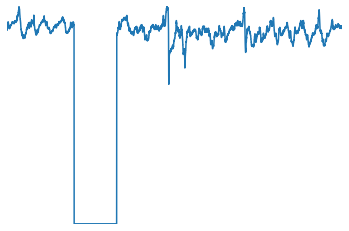

1366


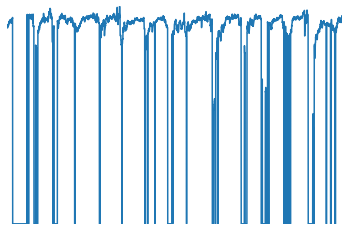

1193


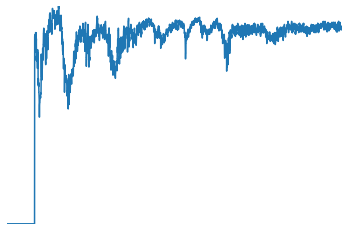

1245


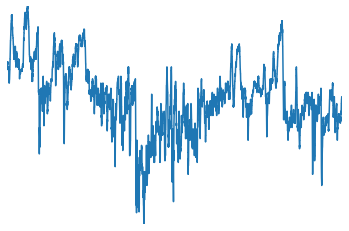

1287


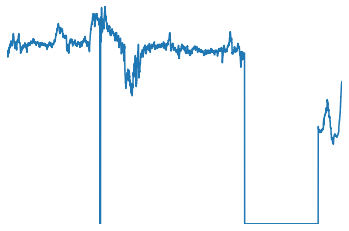

1051


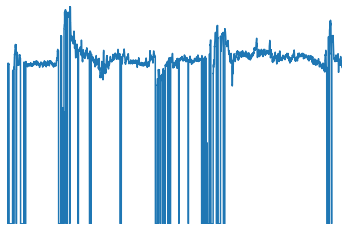

1377


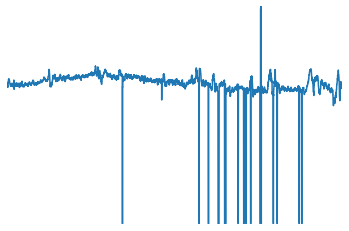

1153


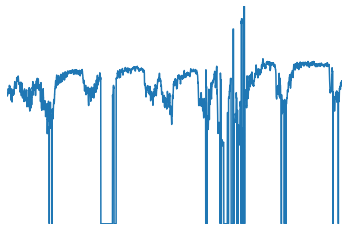

1454


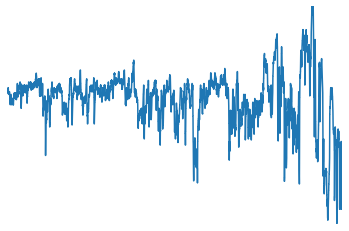

1175


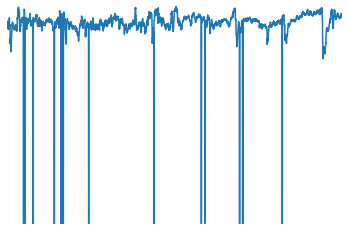

1439


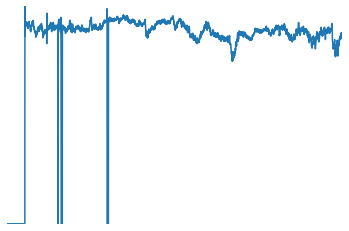

1188


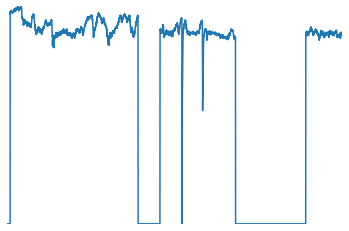

1421


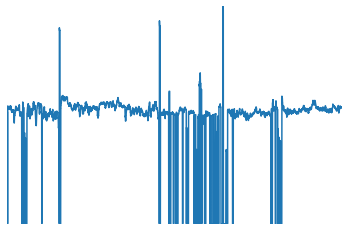

1104


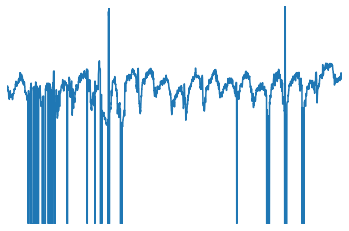

1208


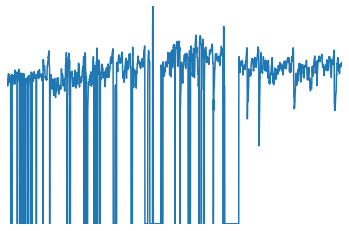

1328


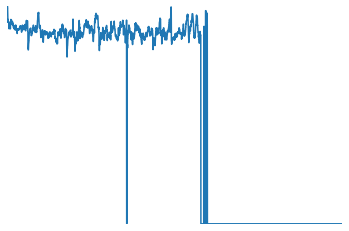

1475


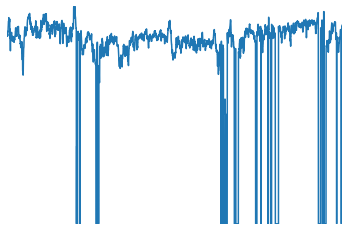

2025


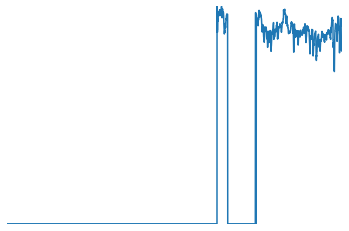

1314


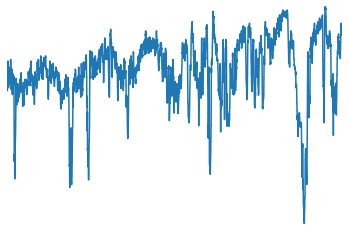

1211


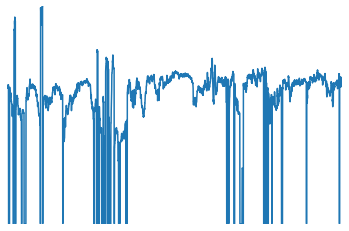

1382


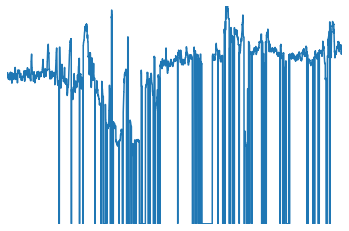

1242


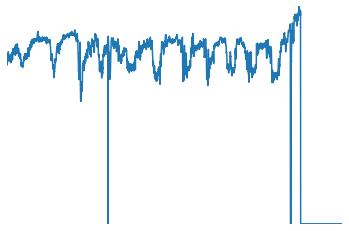

1463


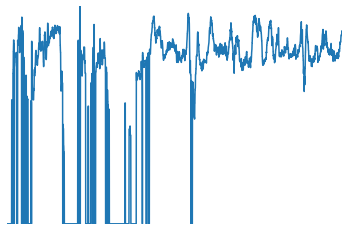

1310


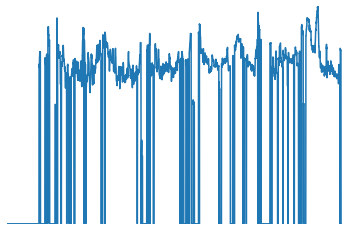

1068


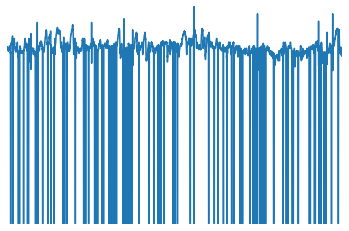

1320


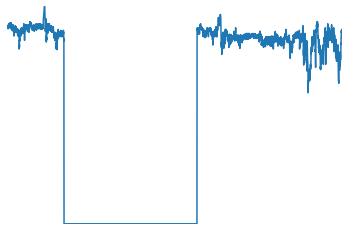

1388


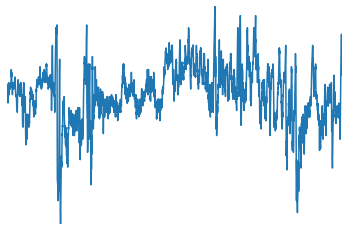

1025


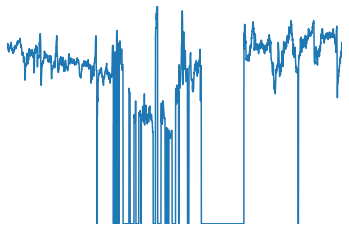

1137


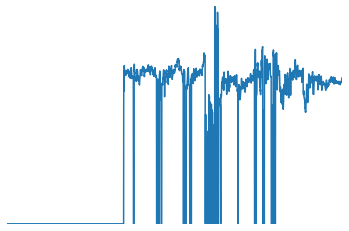

1092


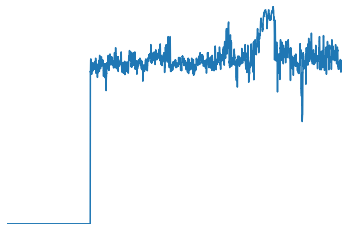

1184


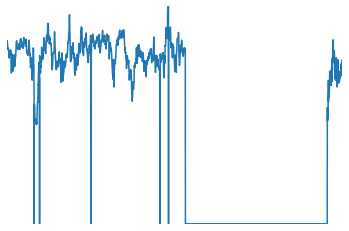

1471


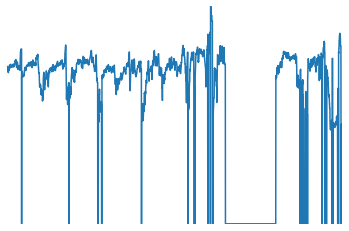

1435


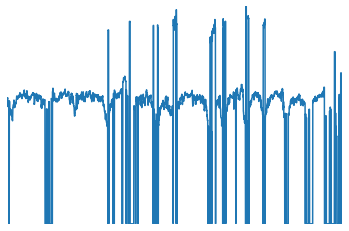

1308


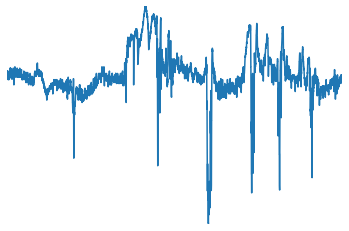

1033


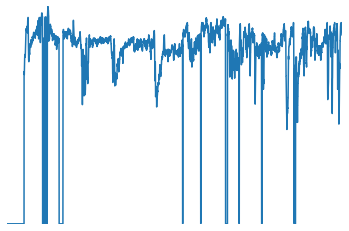

1322


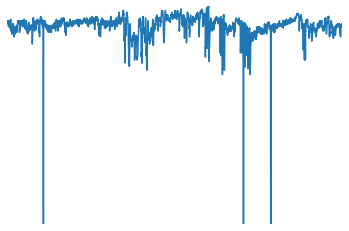

1392


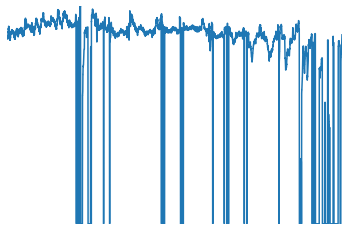

1404


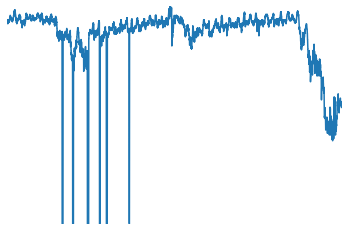

1013


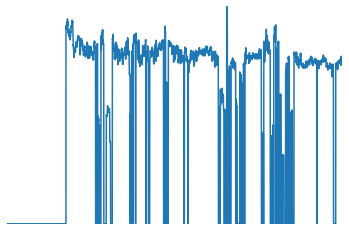

1231


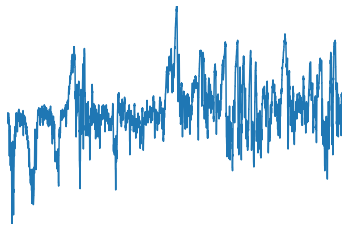

1372


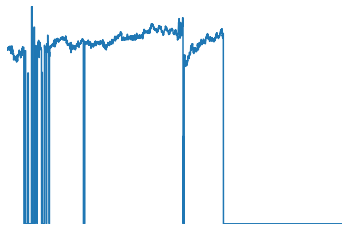

1309


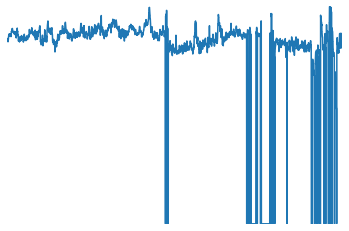

1037


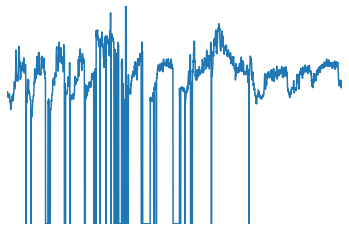

1136


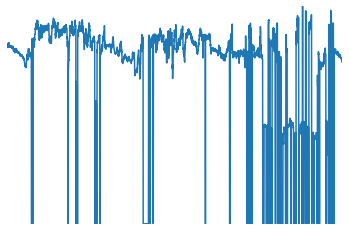

1072


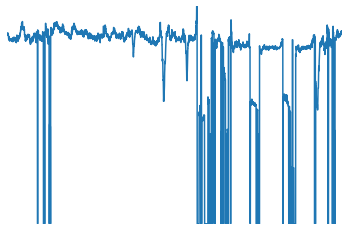

1171


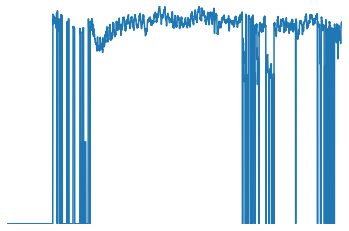

1224


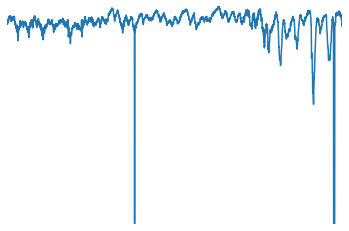

1209


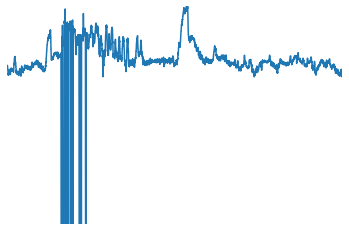

1170


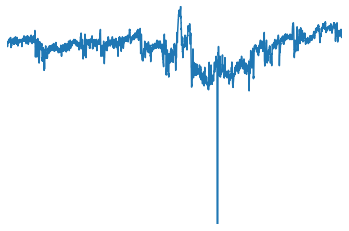

1250


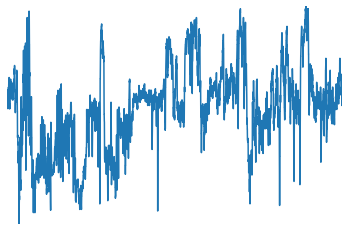

1256


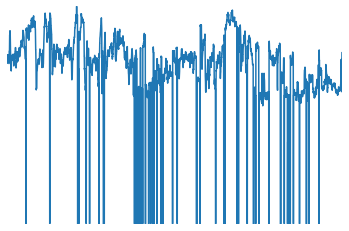

1397


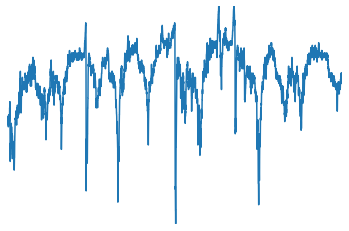

1401


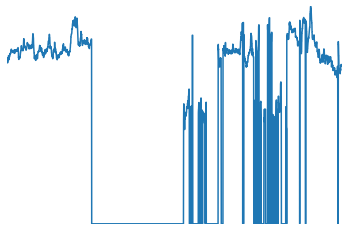

1395


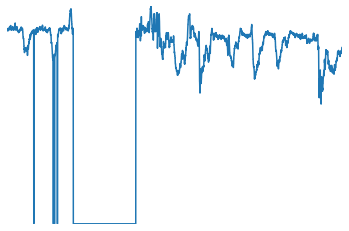

1428


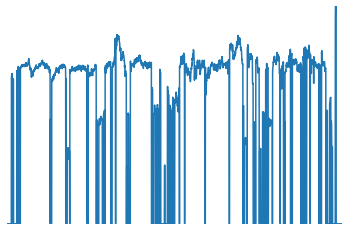

1056


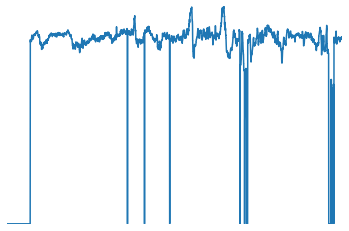

1356


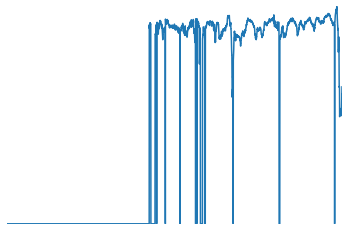

1115


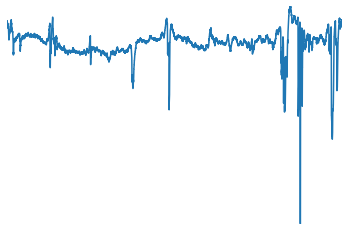

1444


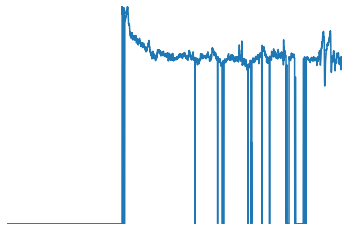

1499


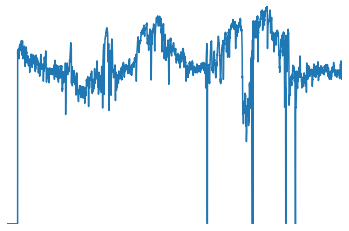

1282


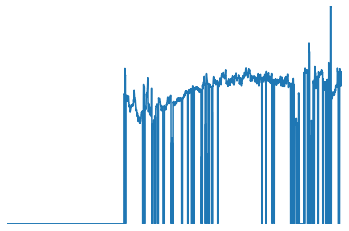

1059


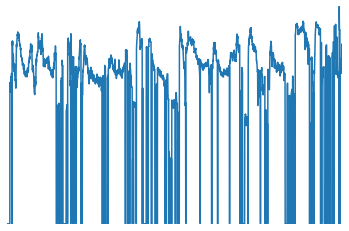

1065


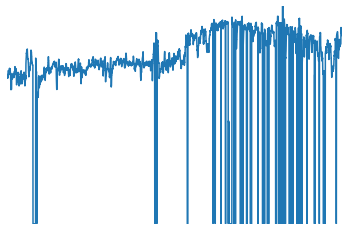

1371


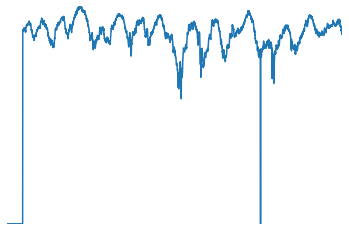

1265


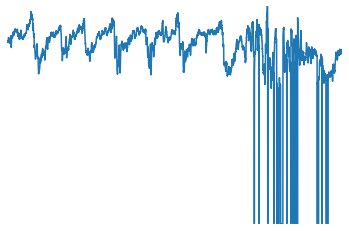

1484


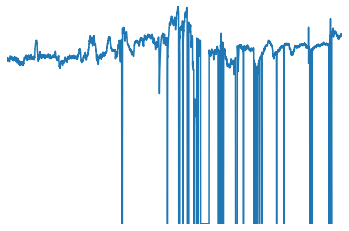

1476


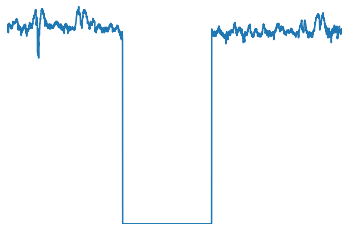

1485


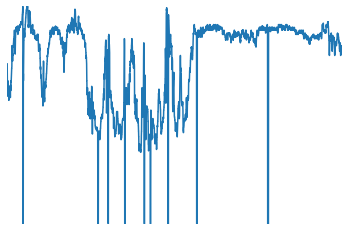

1187


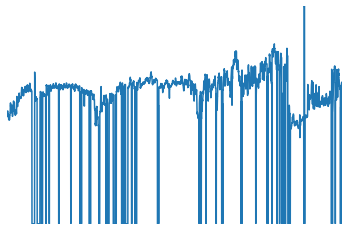

1012


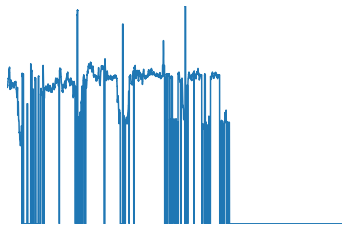

1207


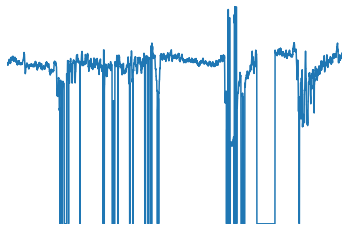

1505


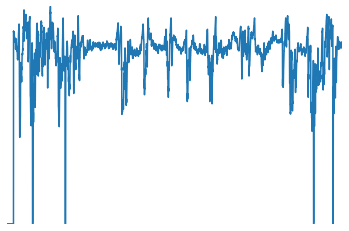

1490


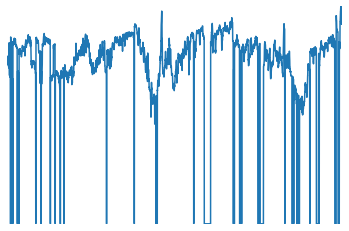

1396


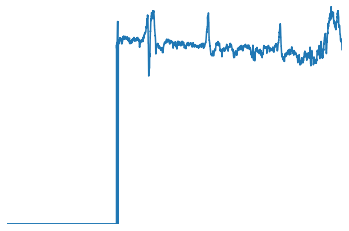

1424


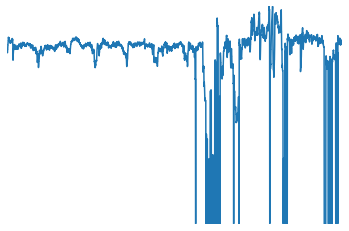

1254


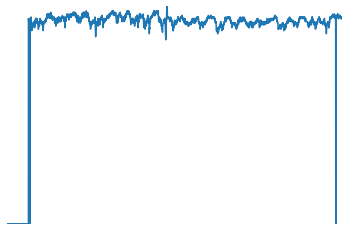

2032


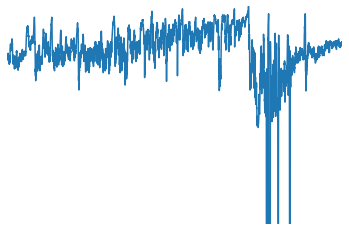

1230


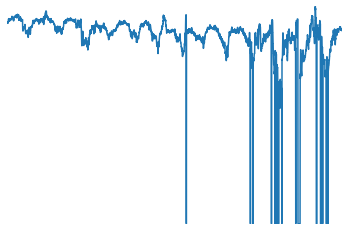

1135


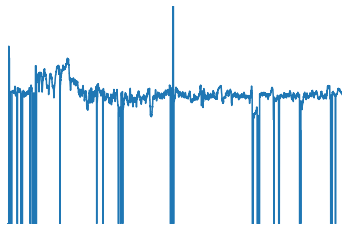

1159


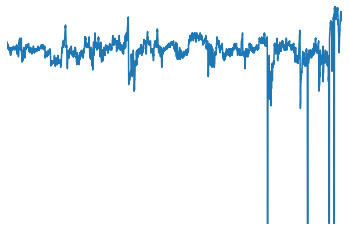

1318


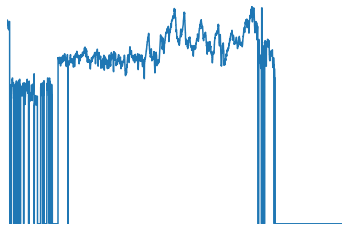

1022


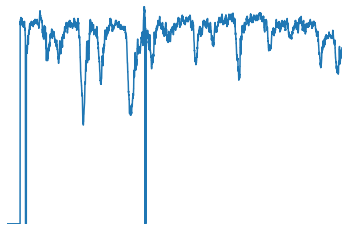

1457


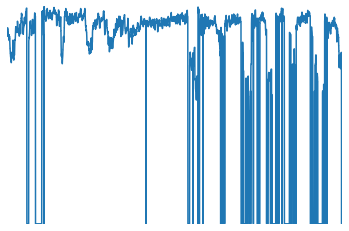

1139


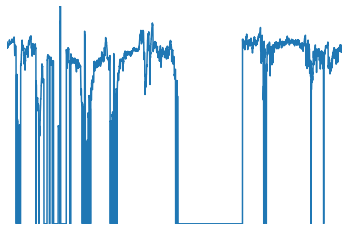

2013


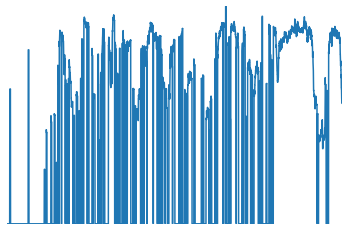

1212


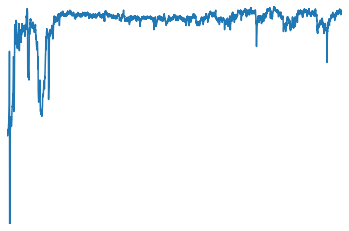

1078


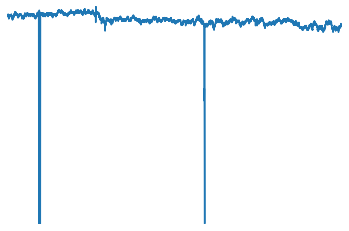

1130


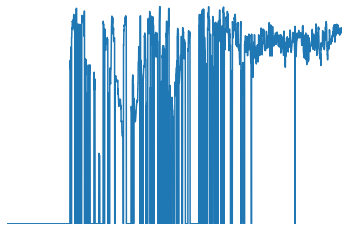

1363


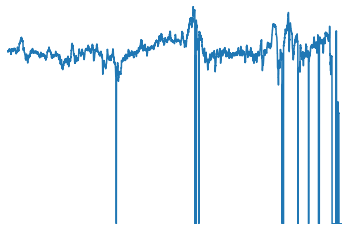

1015


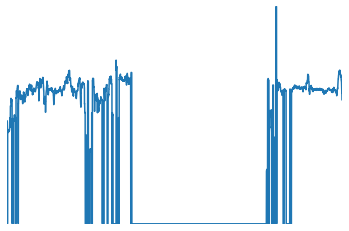

1210


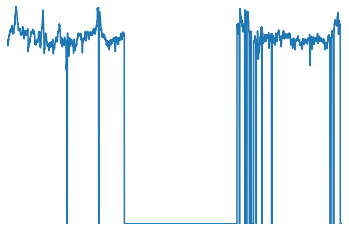

1185


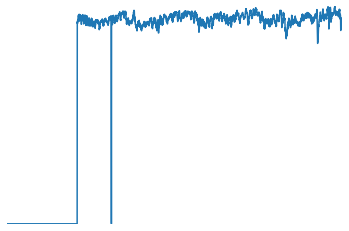

2037


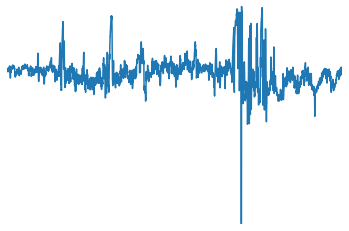

1086


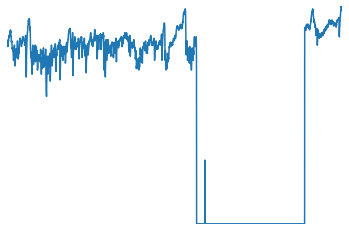

1030


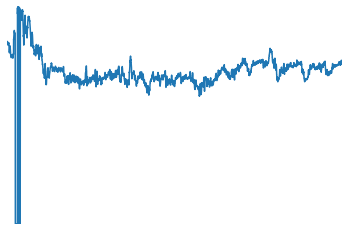

1084


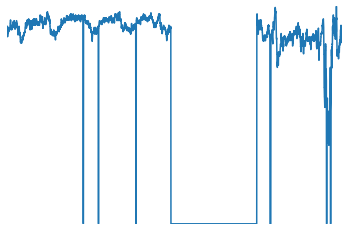

1251


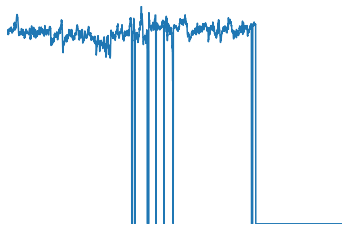

1459


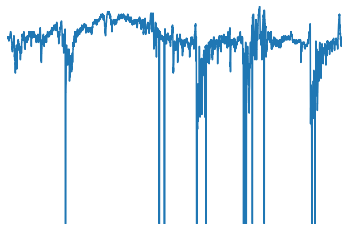

1234


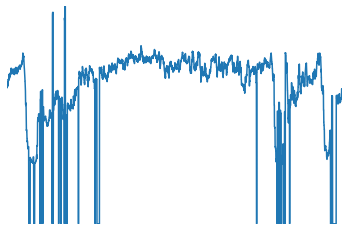

1504


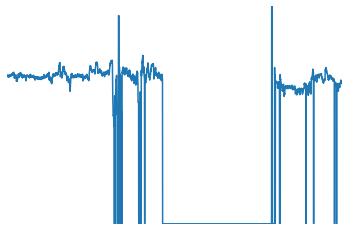

1398


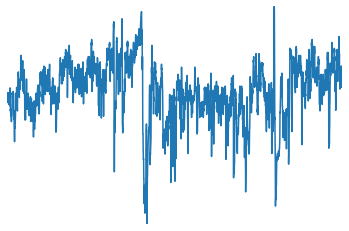

1334


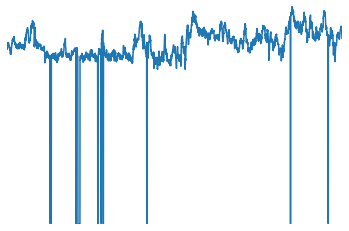

1096


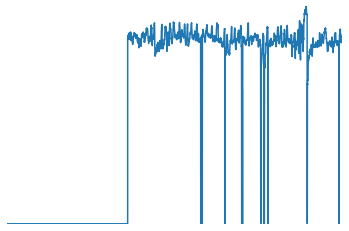

2012


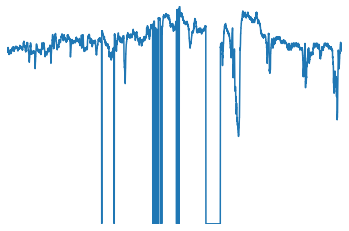

1154


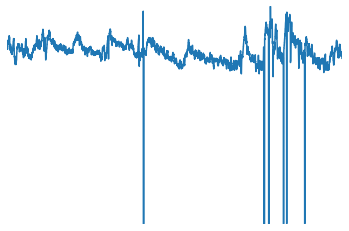

1204


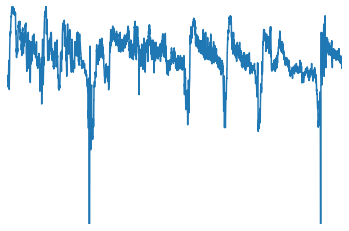

1196


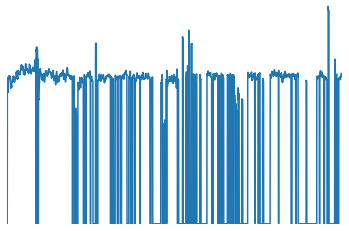

1007


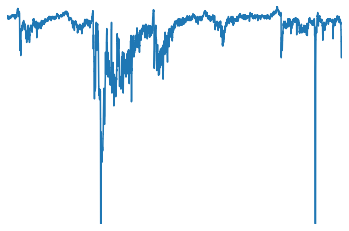

1093


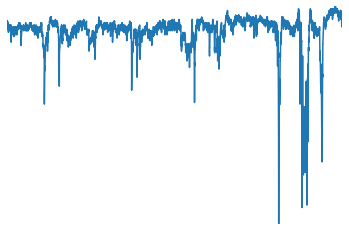

2041


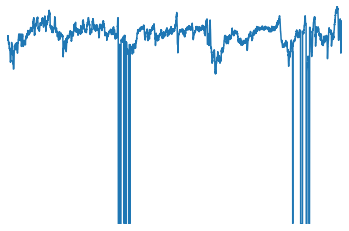

1091


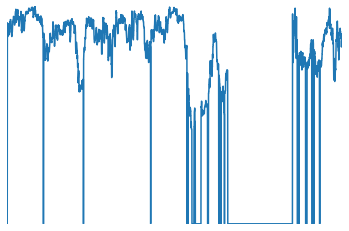

2003


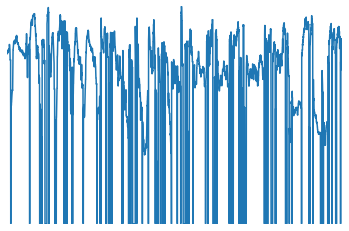

1066


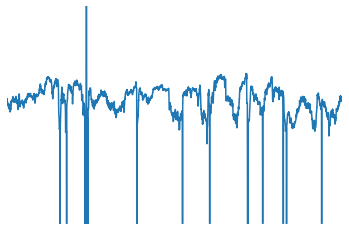

1364


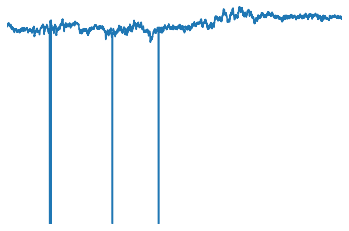

1429


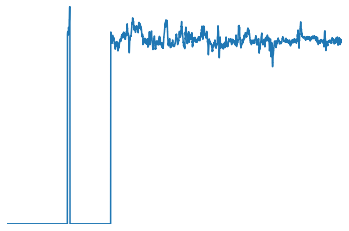

1197


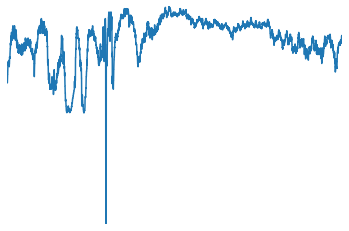

1164


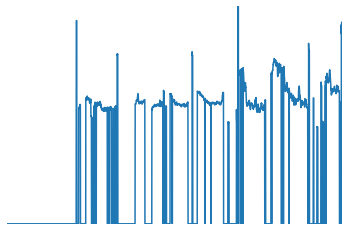

1271


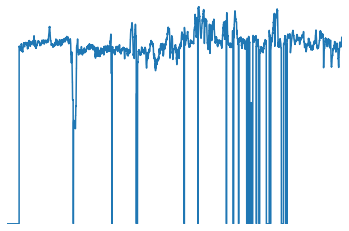

1447


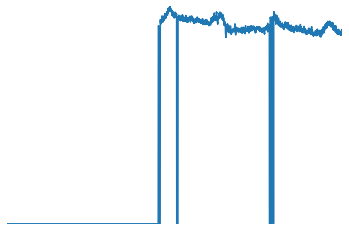

1123


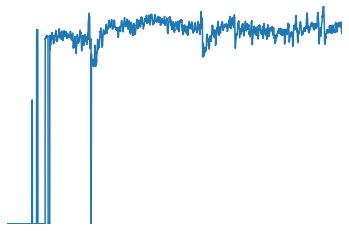

1225


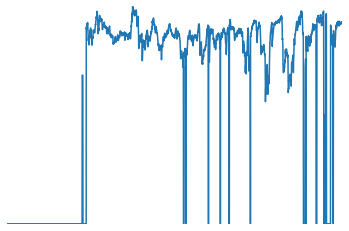

1157


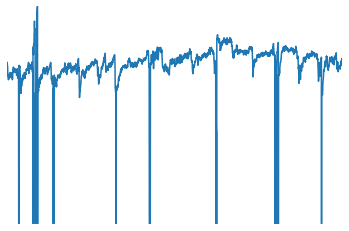

1260


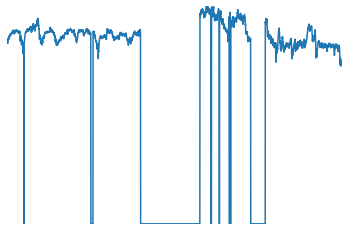

1235


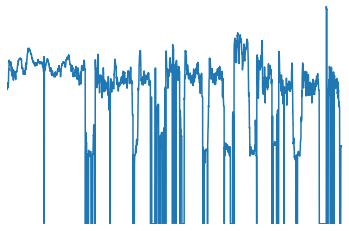

1496


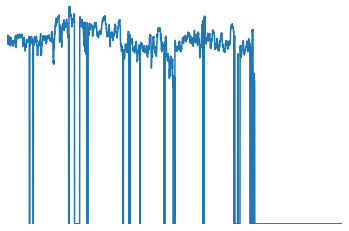

1191


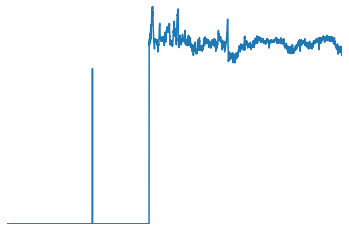

2005


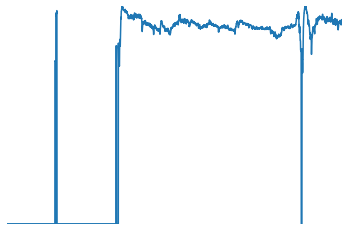

1453


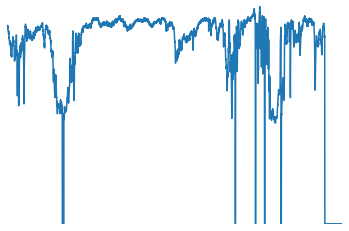

2033


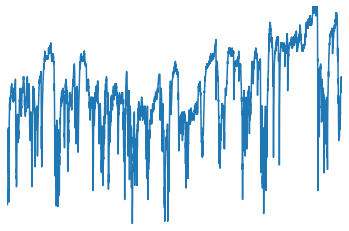

2021


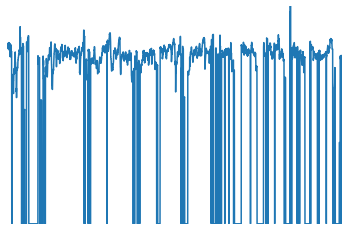

1006


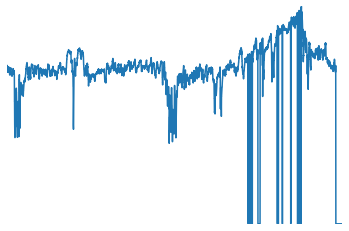

1501


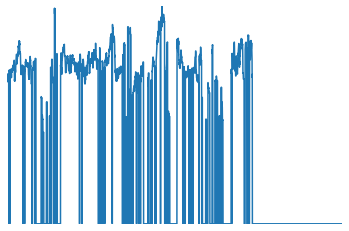

1216


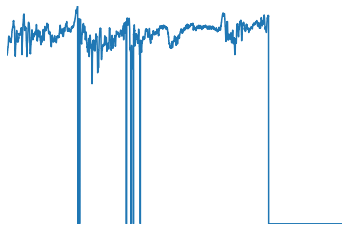

1451


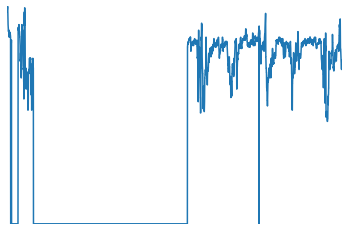

1445


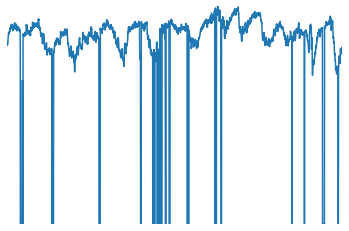

1218


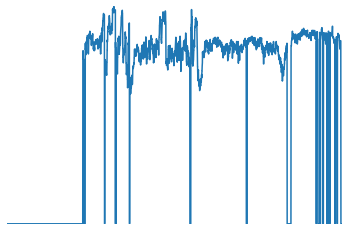

1283


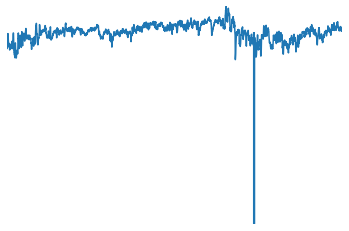

1156


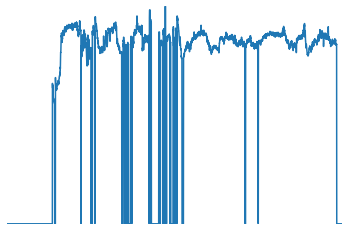

1112


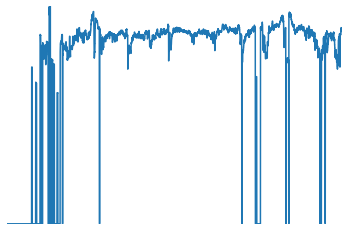

1186


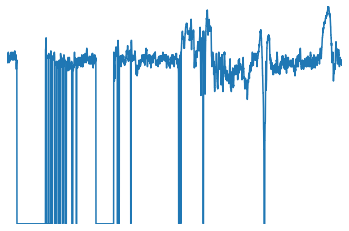

1353


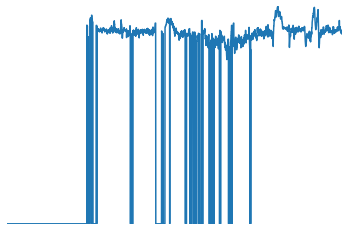

1277


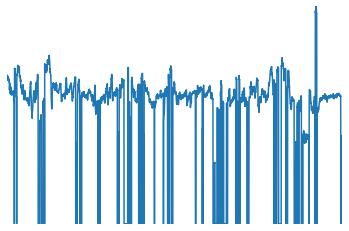

1365


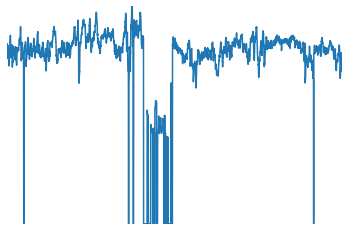

1087


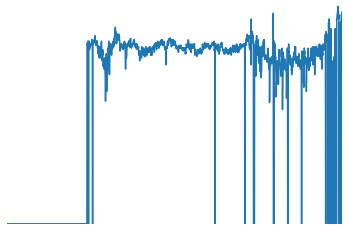

1301


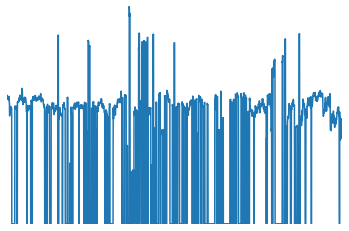

1483


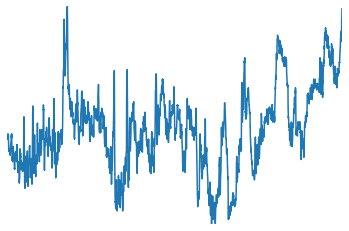

1370


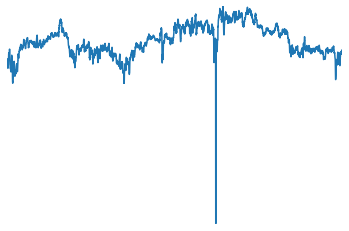

1110


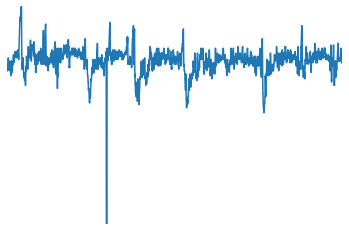

1312


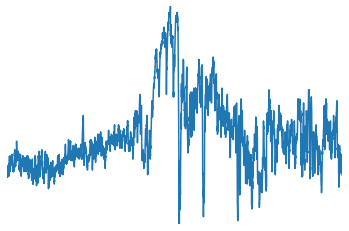

1074


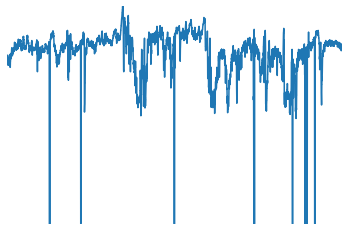

2030


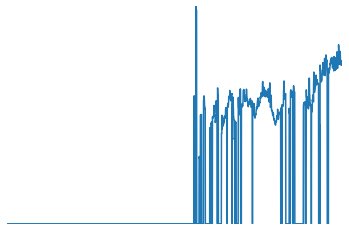

1335


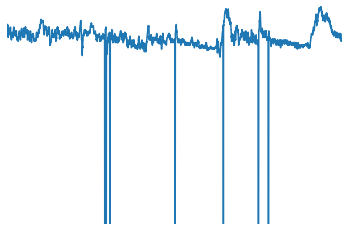

1041


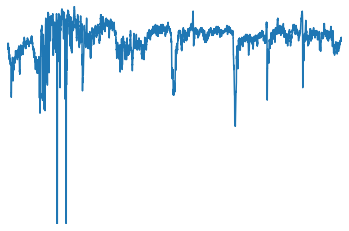

1411


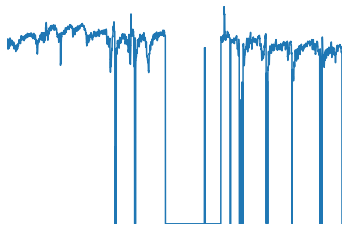

1181


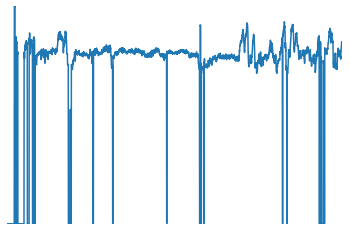

1129


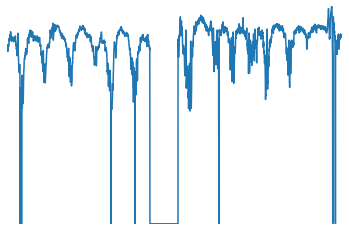

1294


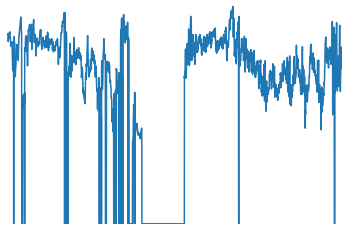

1058


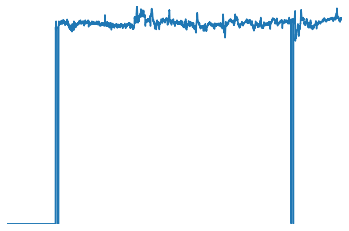

1288


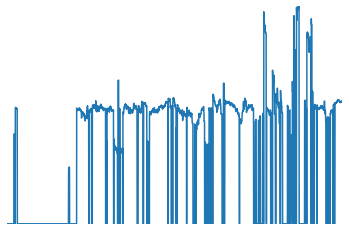

1465


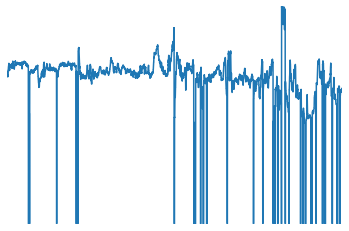

1305


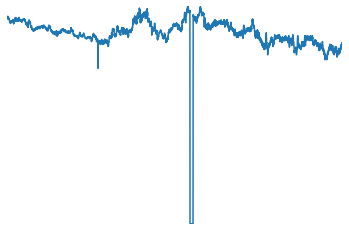

1381


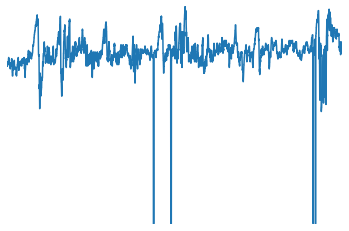

1150


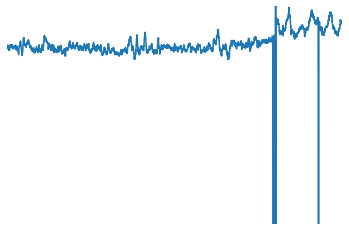

1412


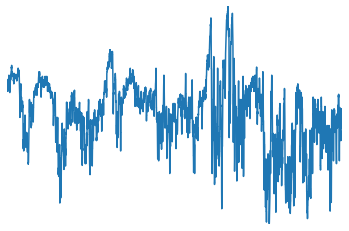

1405


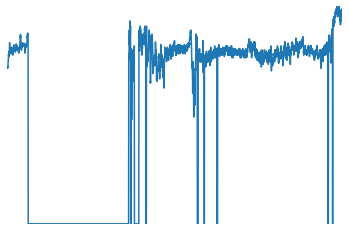

1502


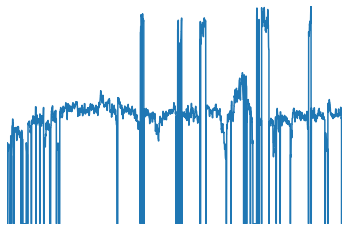

1487


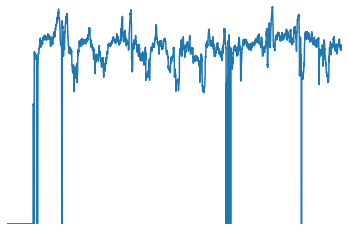

1470


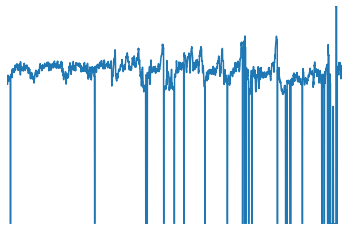

1241


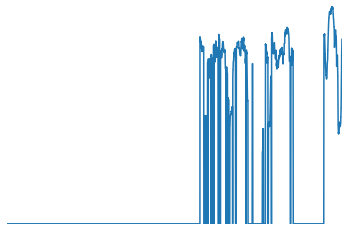

1107


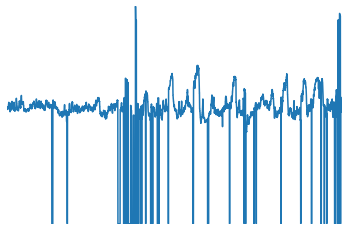

1049


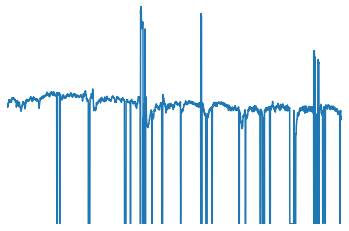

1122


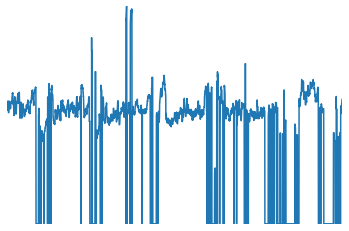

1128


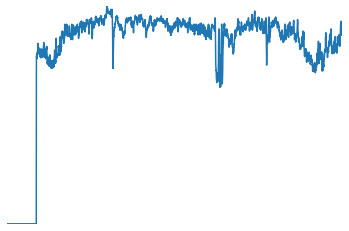

1088


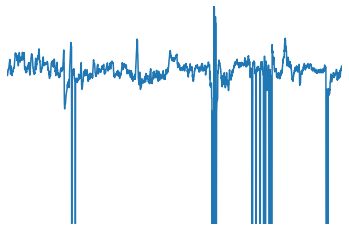

1143


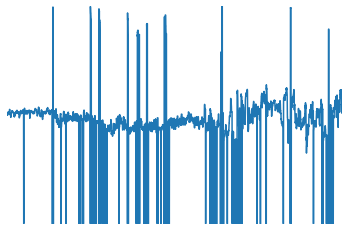

1018


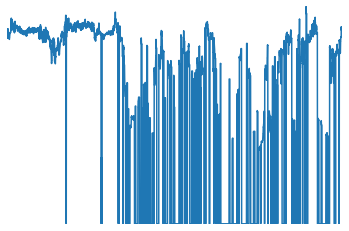

1482


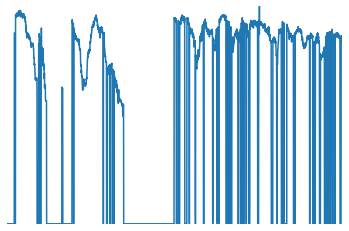

2023


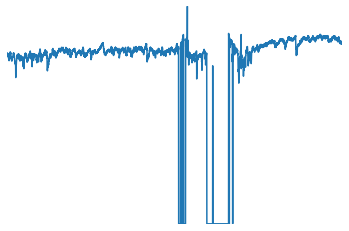

1073


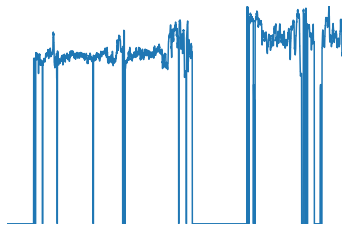

1448


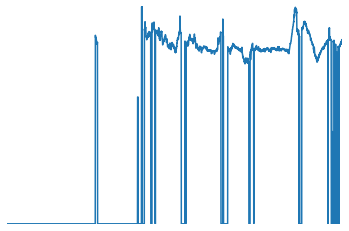

2045


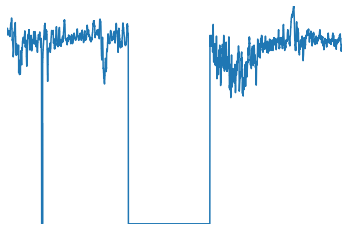

1289


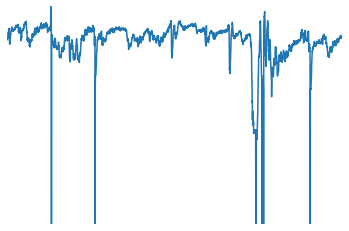

2022


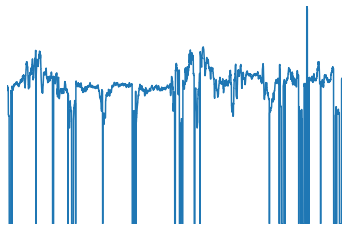

1003


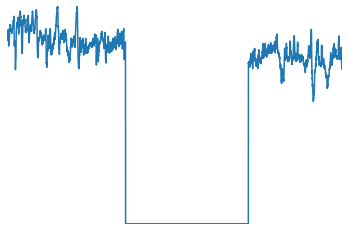

1430


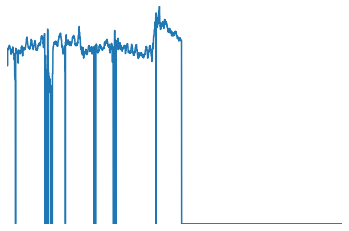

1227


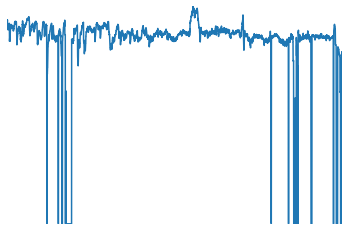

1099


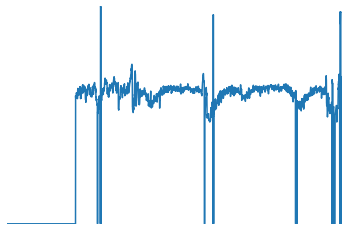

1255


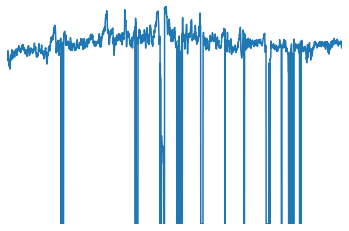

1085


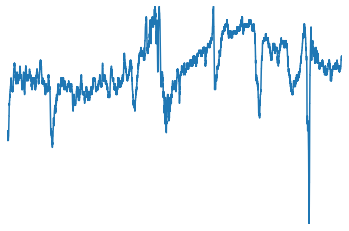

1134


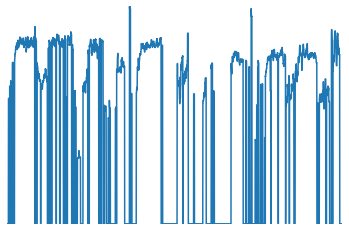

1461


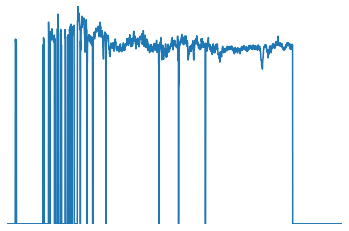

1069


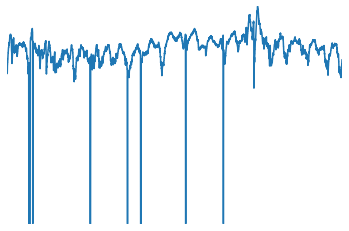

1221


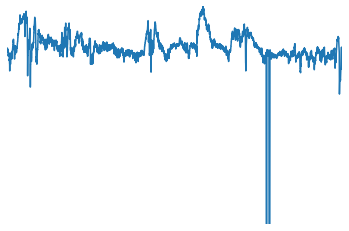

1167


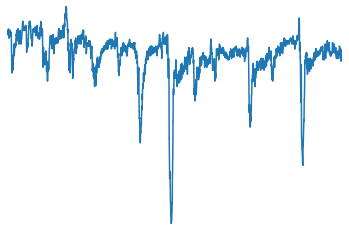

1168


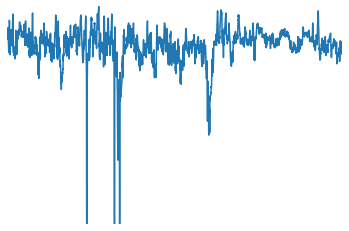

1259


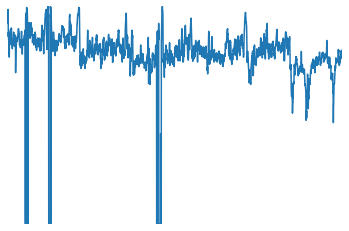

1390


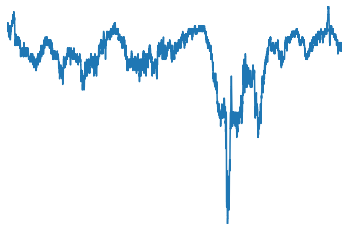

1192


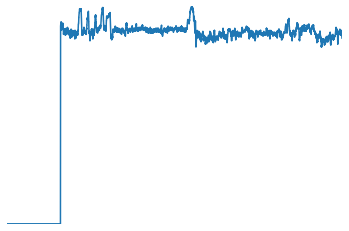

1228


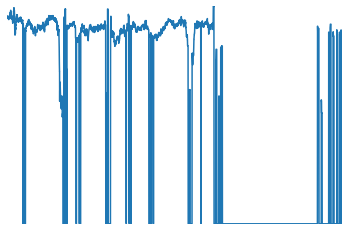

1267


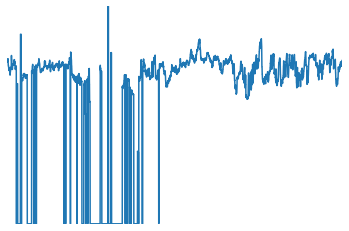

1385


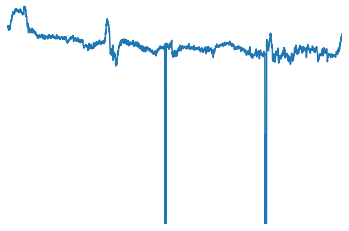

1162


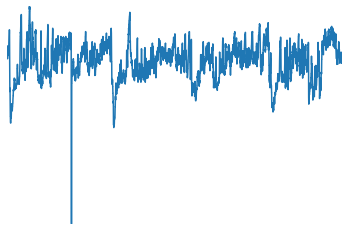

1299


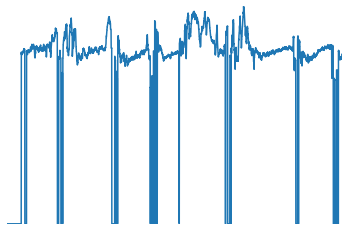

1215


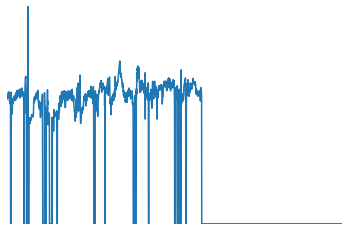

1337


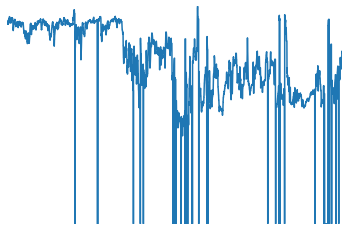

1379


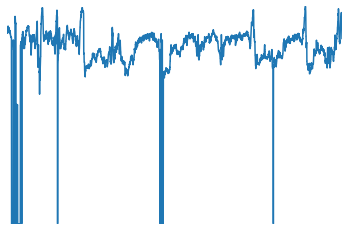

1001


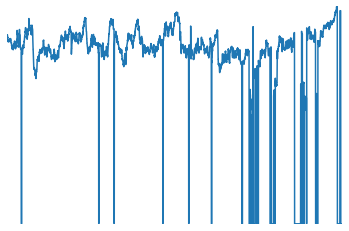

1179


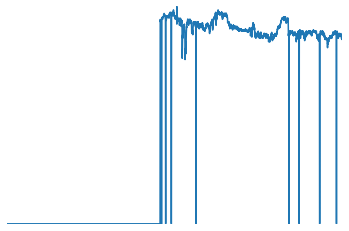

1433


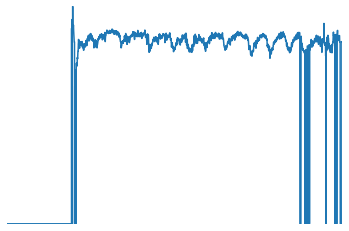

1378


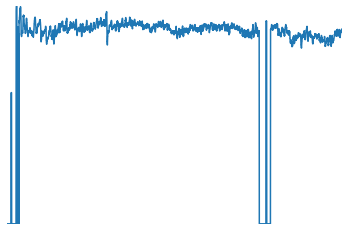

1323


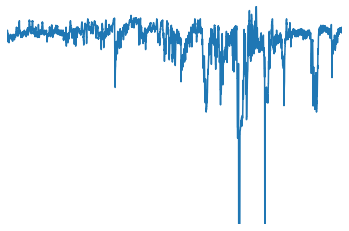

1089


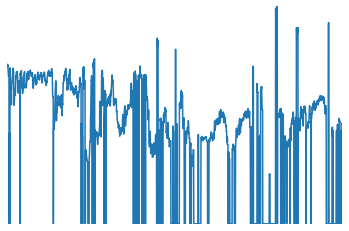

2042


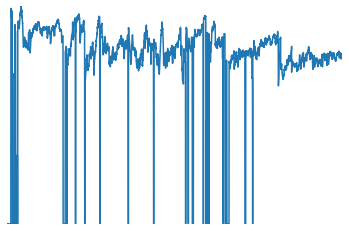

1213


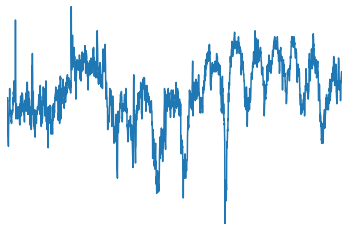

1347


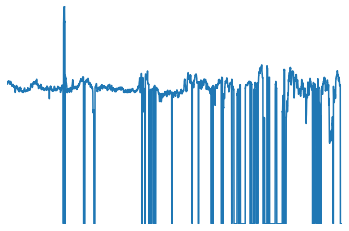

2016


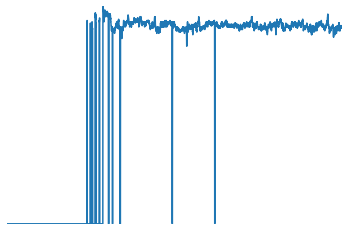

1317


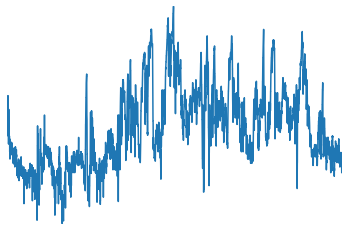

1118


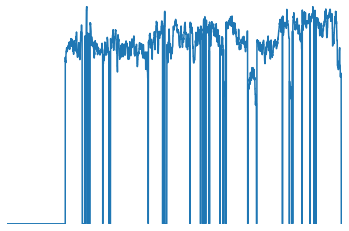

1141


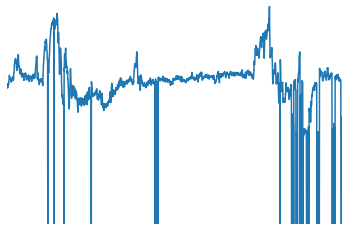

1160


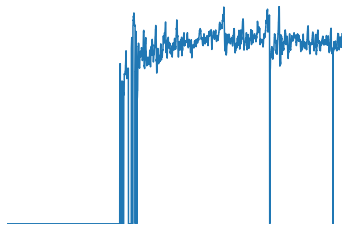

1062


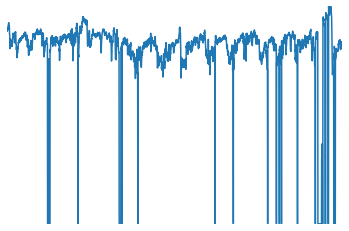

1286


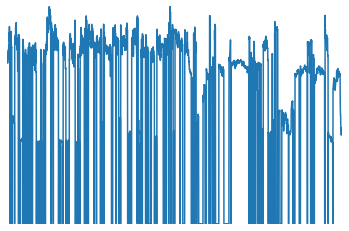

1469


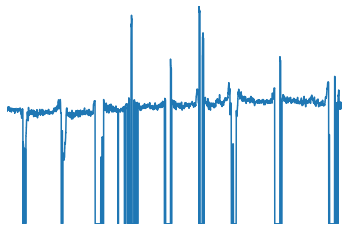

1375


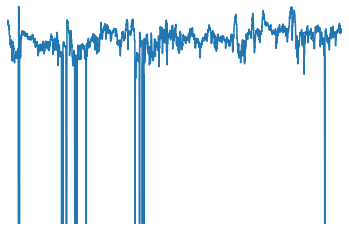

1280


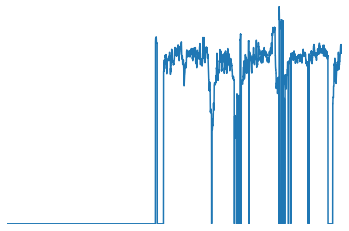

1456


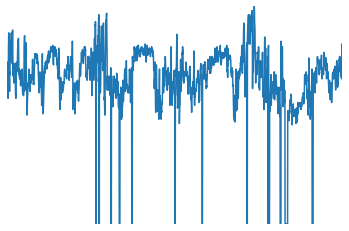

1158


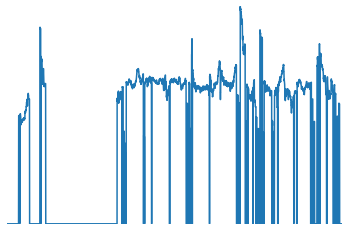

1473


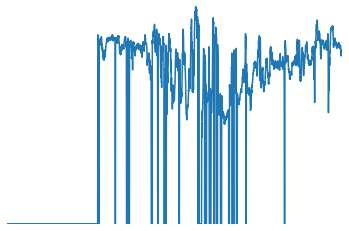

1427


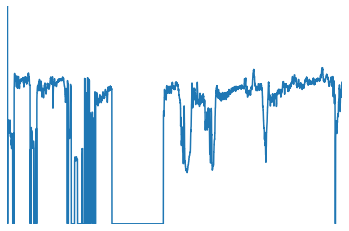

1098


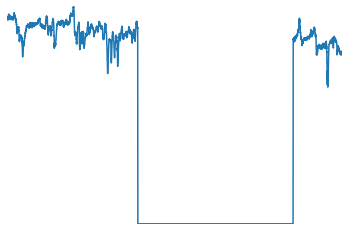

1452


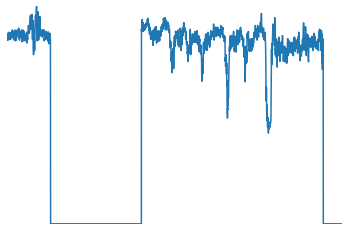

1383


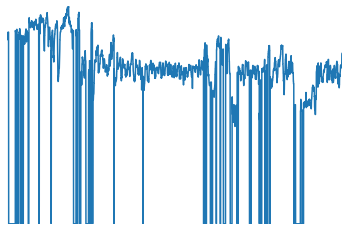

1090


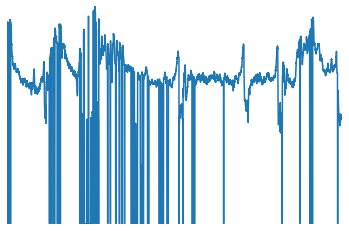

1361


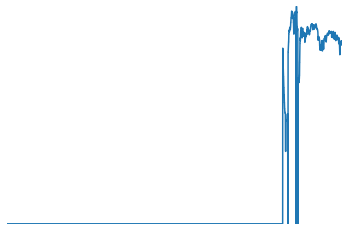

1284


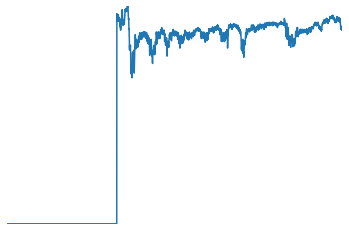

1011


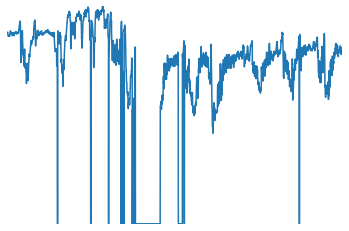

1054


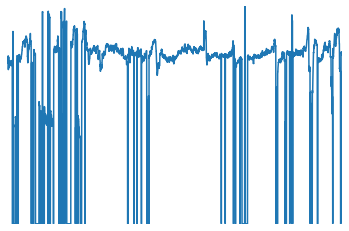

1046


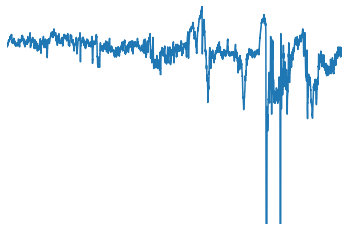

1226


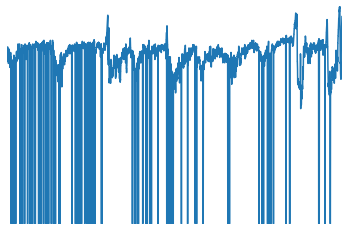

1237


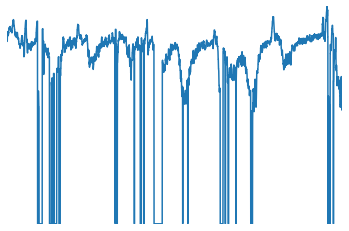

1492


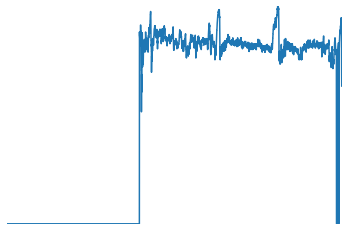

1327


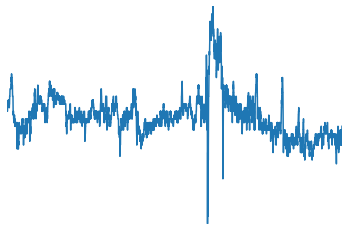

2024


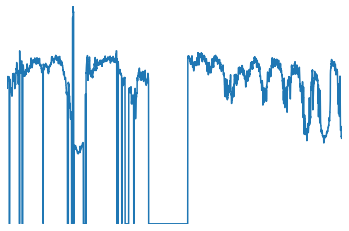

1060


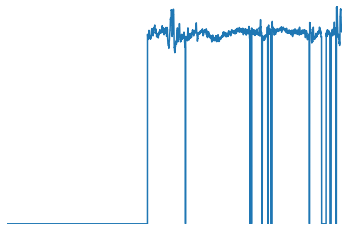

1103


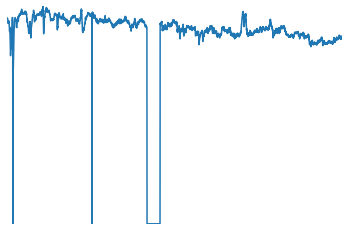

1477


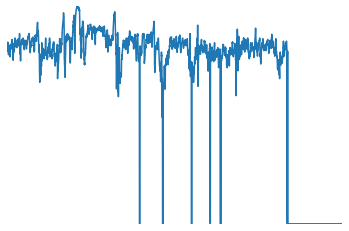

1369


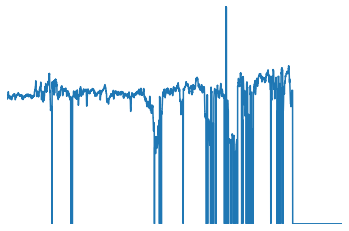

1017


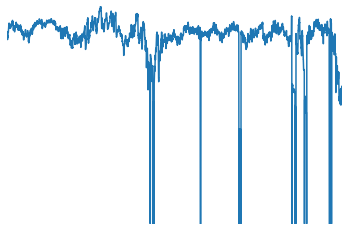

1300


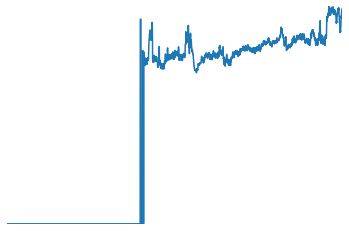

1035


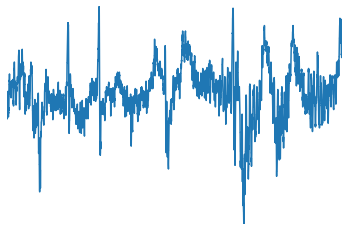

1343


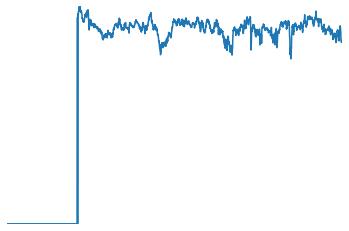

2008


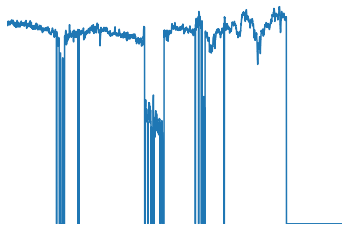

2014


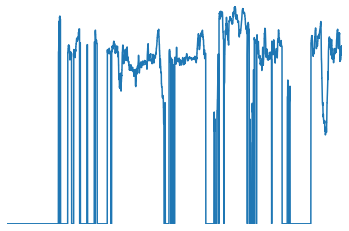

2039


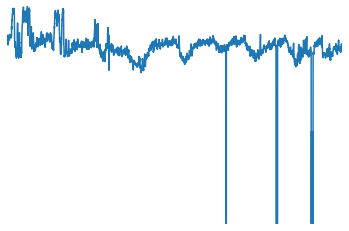

2009


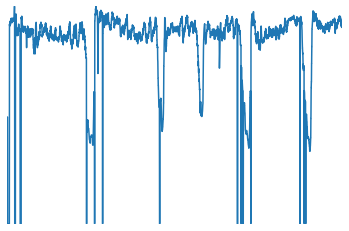

1239


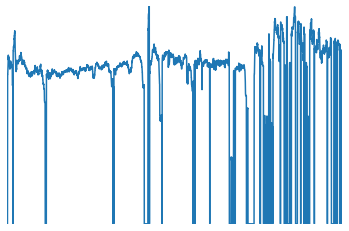

2020


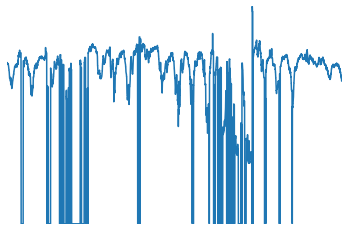

1126


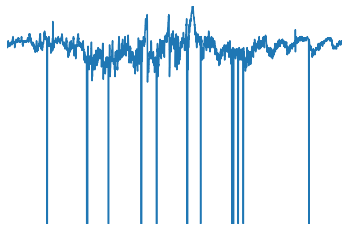

1455


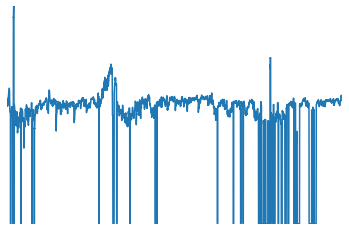

1263


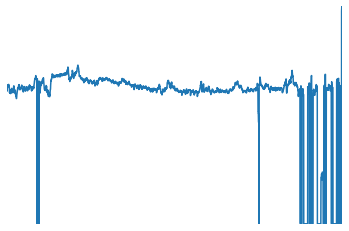

1480


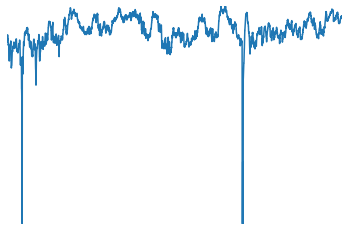

1503


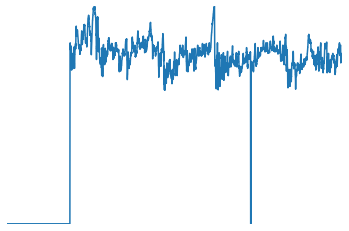

1182


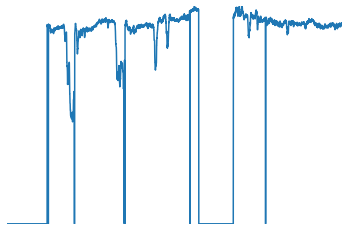

1380


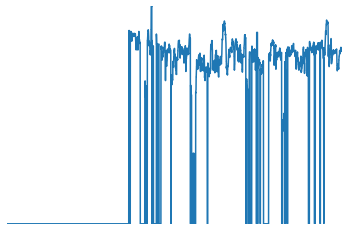

1489


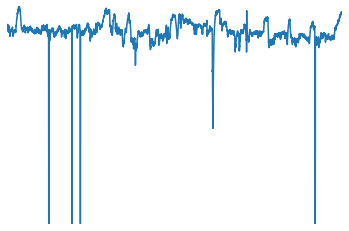

1116


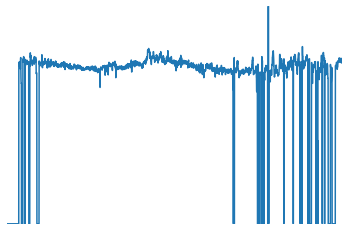

1163


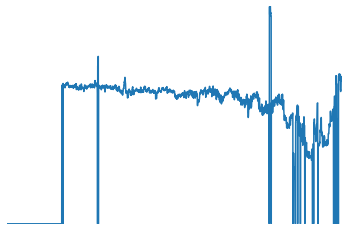

1077


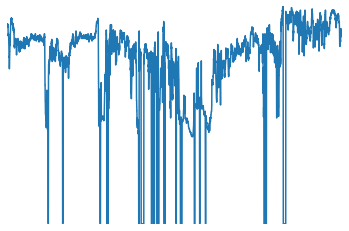

1400


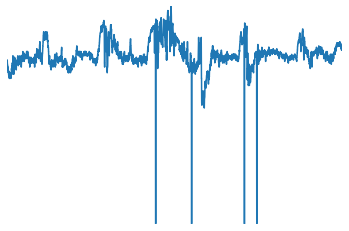

1266


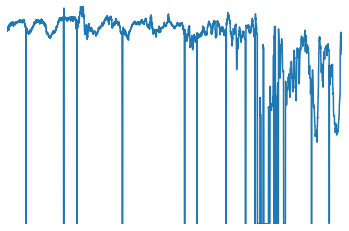

1497


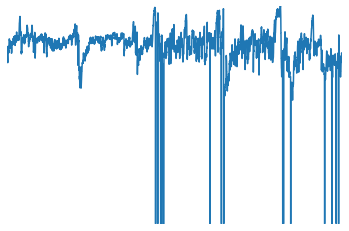

1183


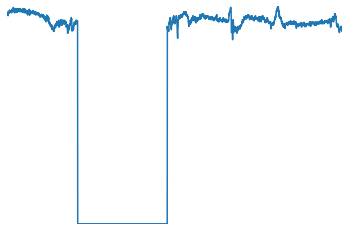

1223


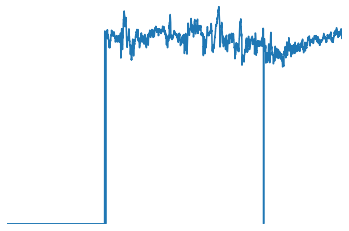

1120


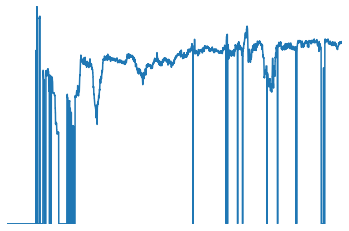

1201


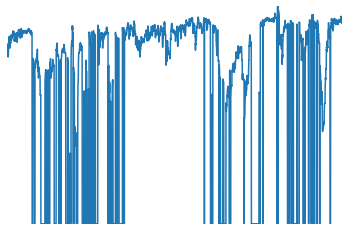

1495


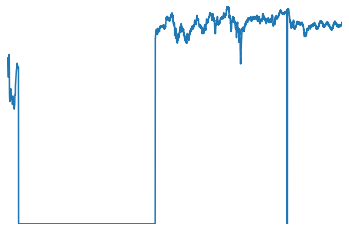

1291


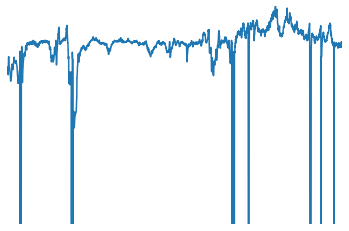

1075


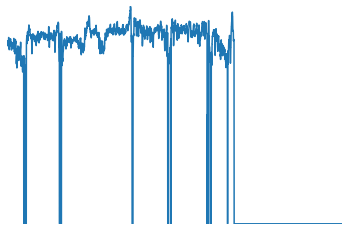

1257


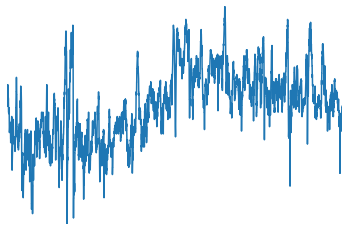

2046


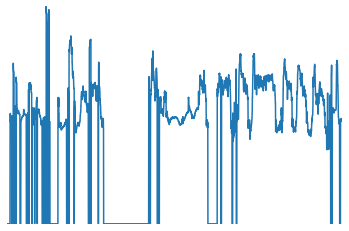

1038


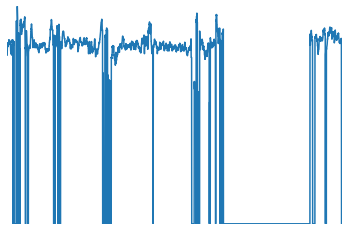

1479


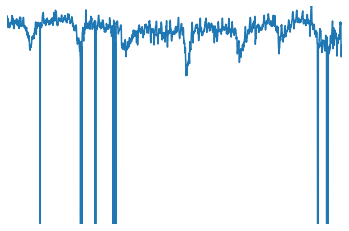

1436


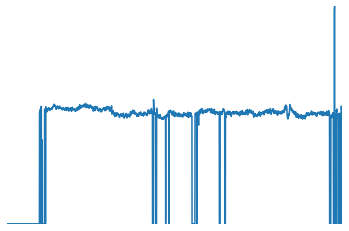

1426


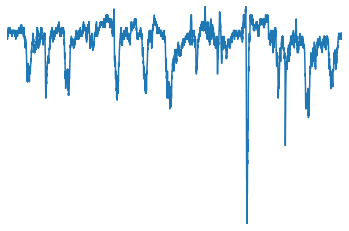

1222


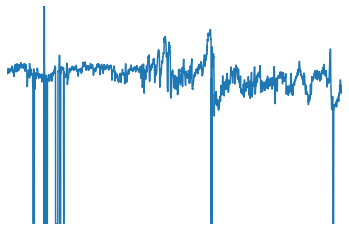

1202


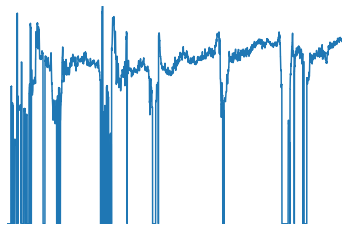

1417


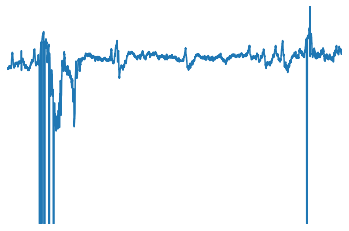

1194


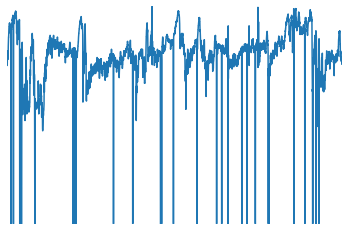

1321


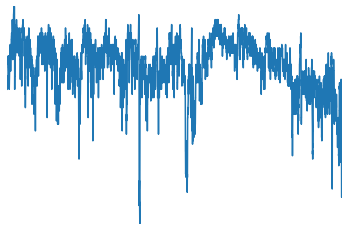

1149


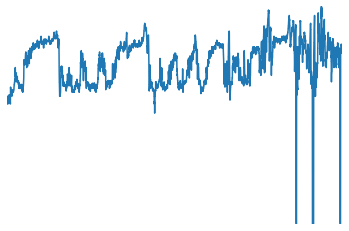

1244


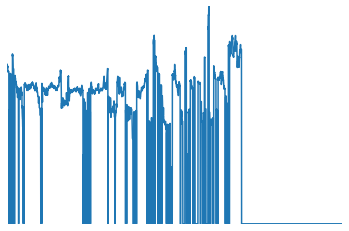

1331


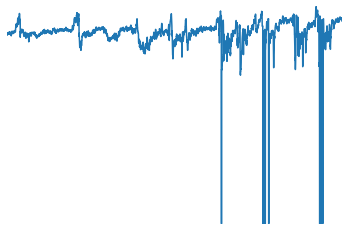

1031


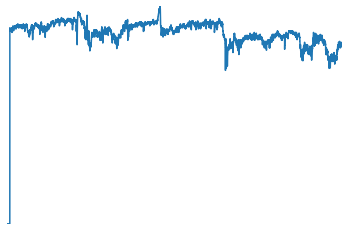

1425


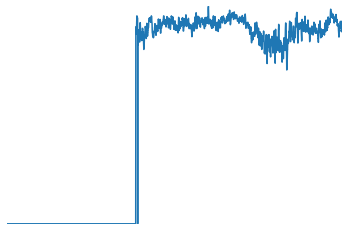

1359


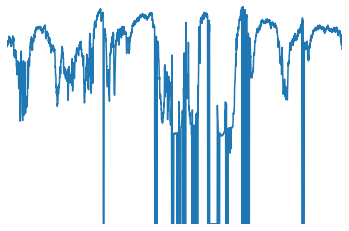

1415


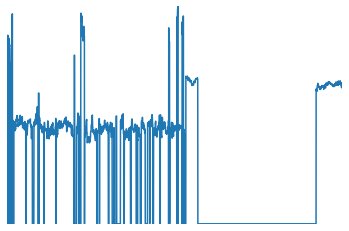

1446


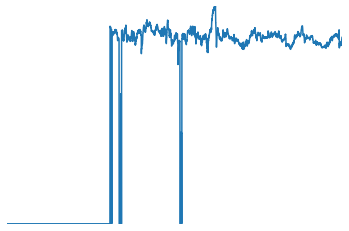

1043


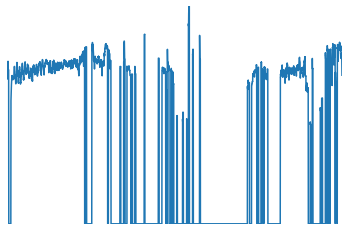

1238


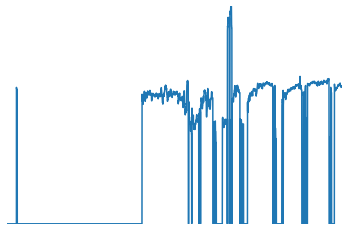

1258


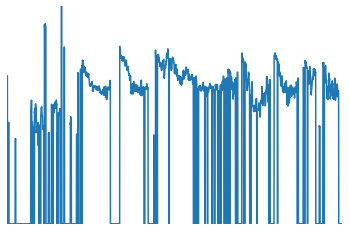

1233


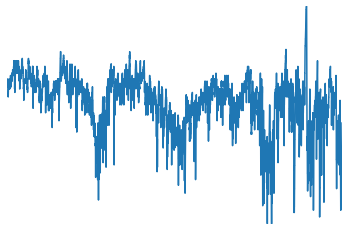

2040


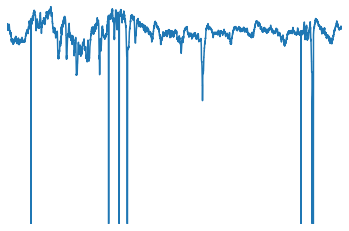

1494


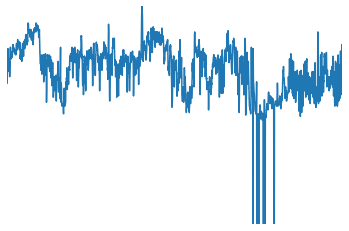

1061


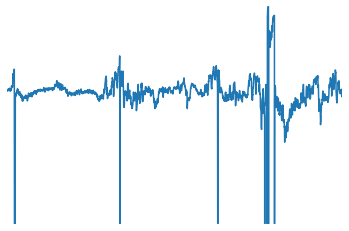

1024


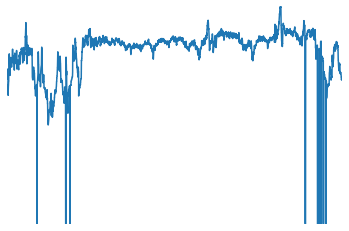

1082


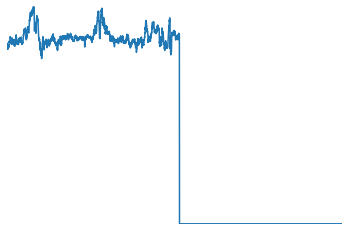

2006


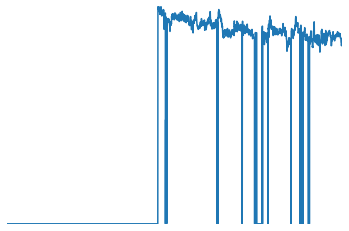

1434


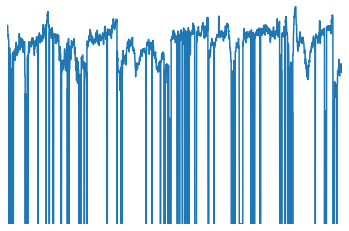

1358


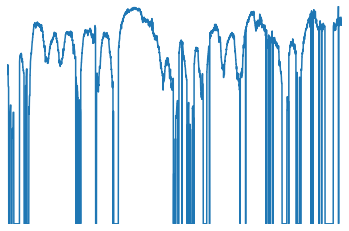

1247


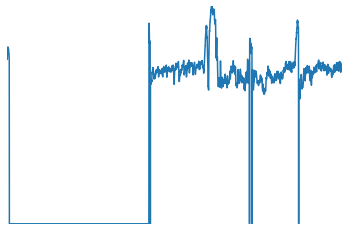

1246


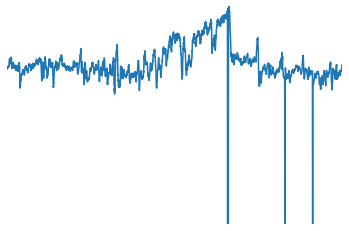

1460


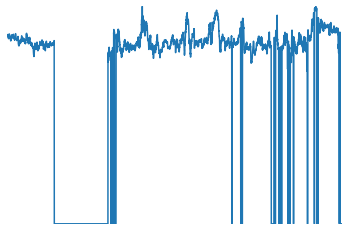

1083


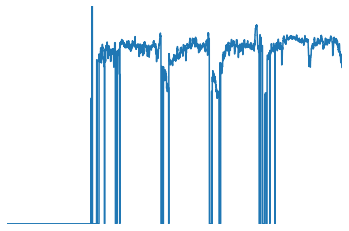

1399


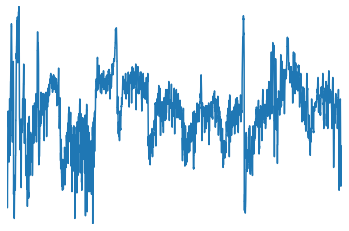

1278


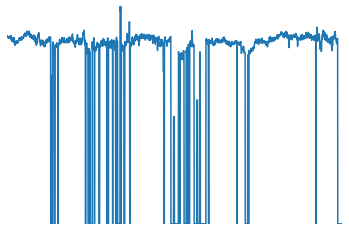

1264


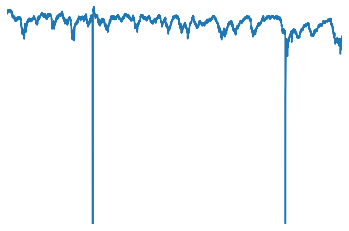

1195


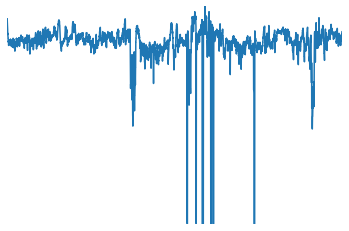

1106


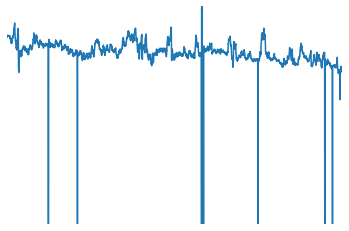

1389


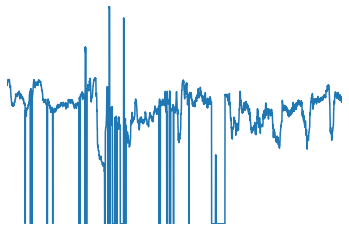

1481


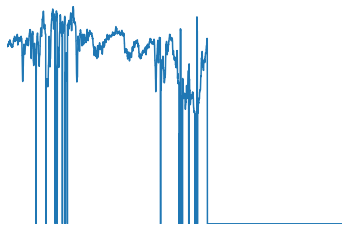

1252


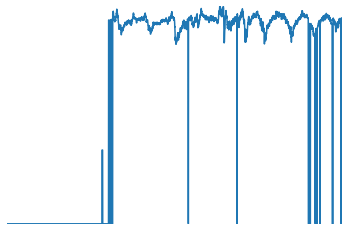

1316


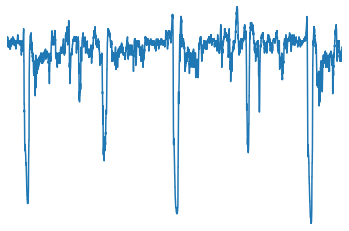

1095


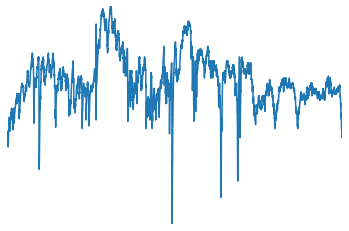

1414


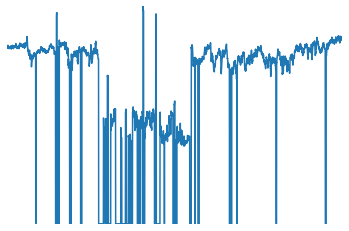

1462


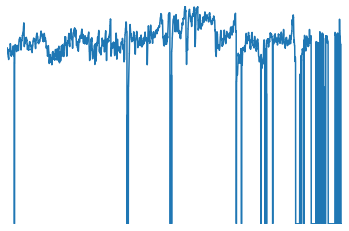

1121


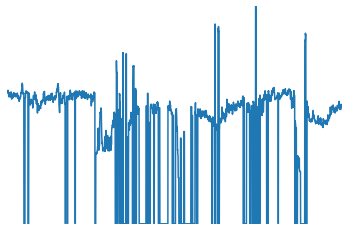

1273


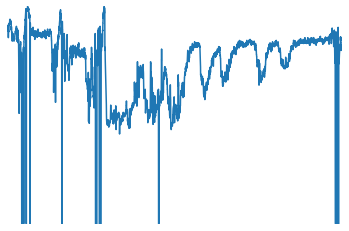

1374


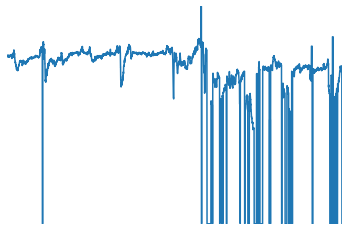

1109


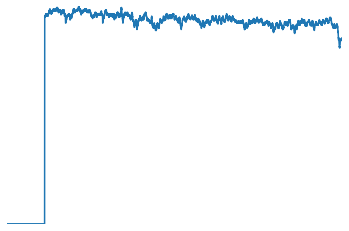

1500


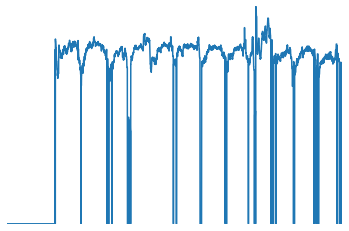

1340


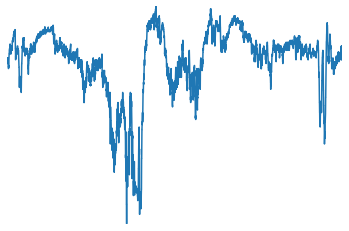

1441


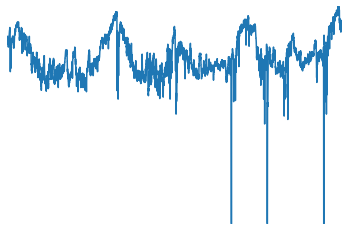

1010


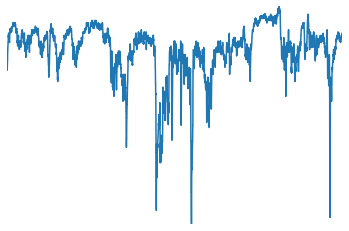

1178


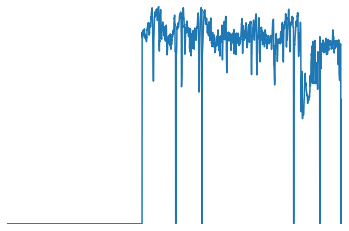

1028


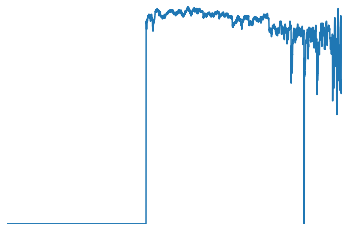

1151


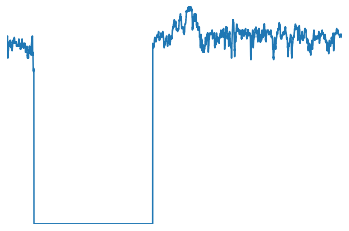

1458


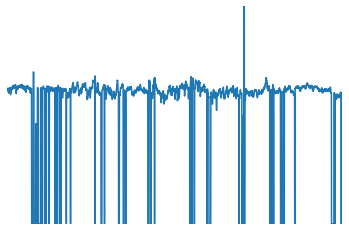

1348


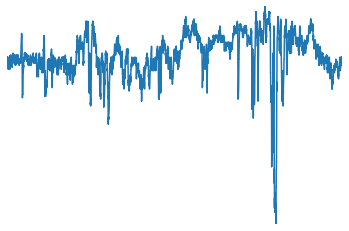

1161


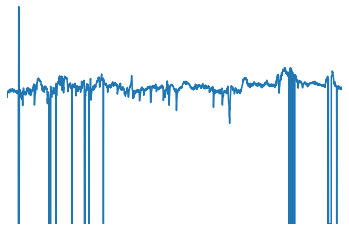

1206


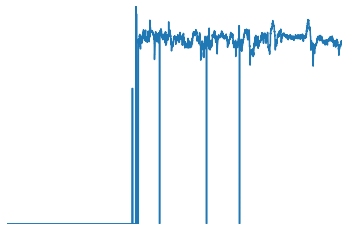

1045


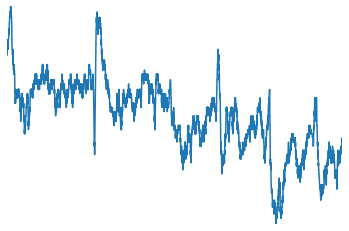

1437


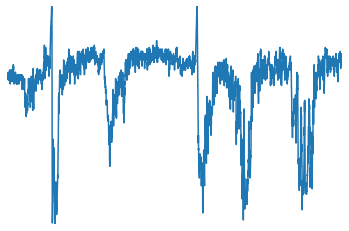

1177


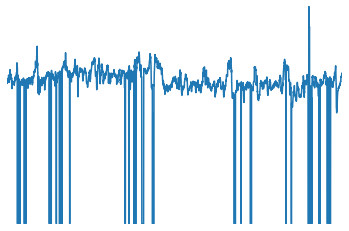

1219


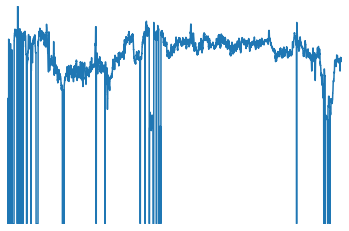

2019


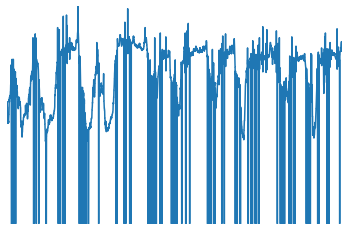

1406


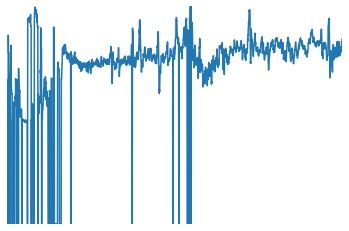

1274


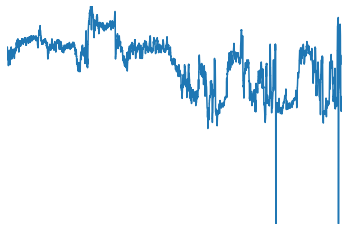

1214


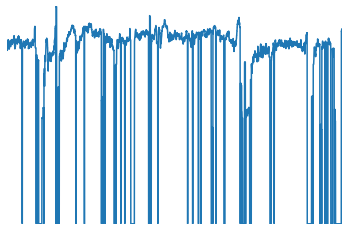

2036


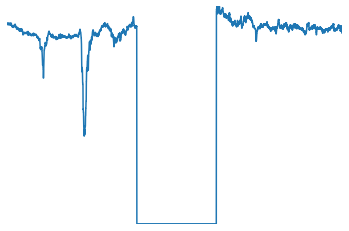

1357


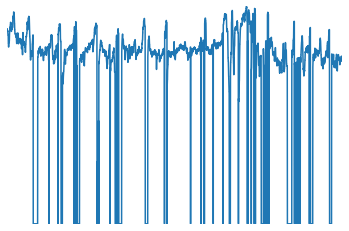

1319


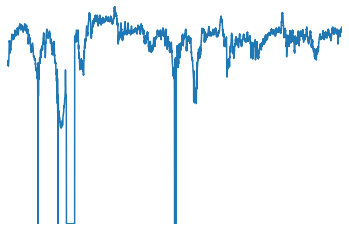

1432


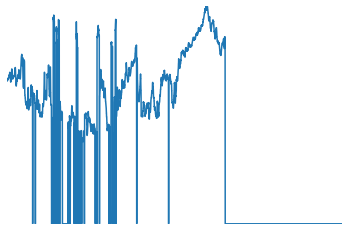

2007


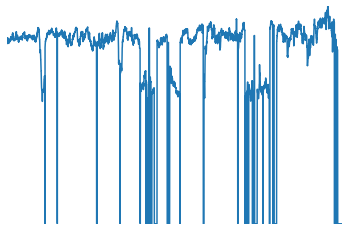

1019


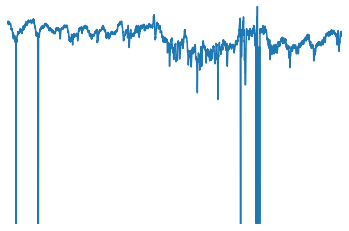

1148


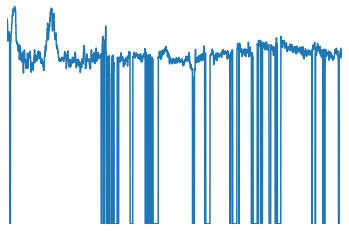

1131


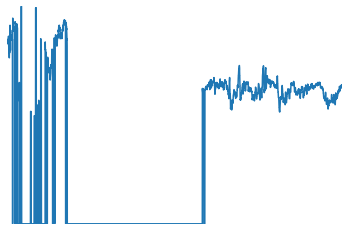

1373


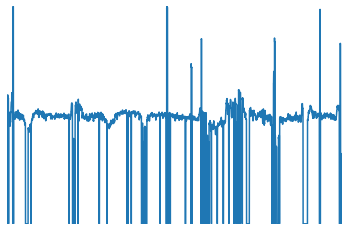

1269


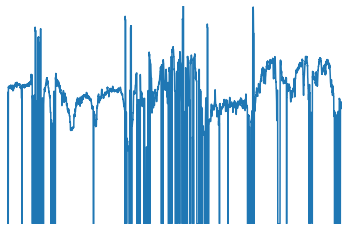

1307


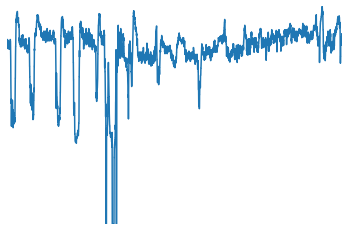

1422


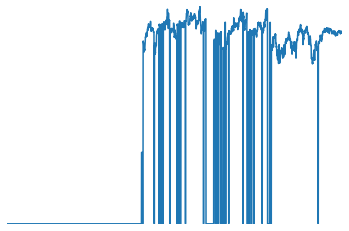

1311


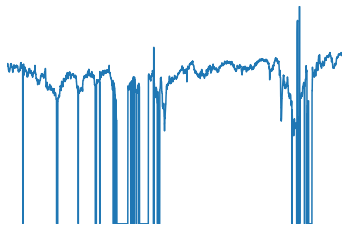

1240


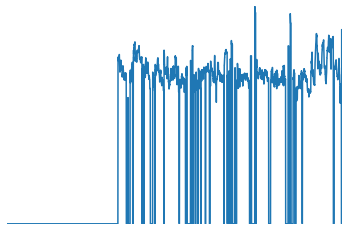

1190


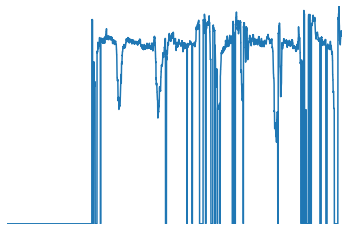

1387


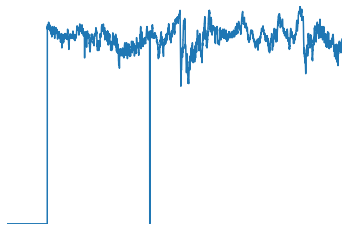

1021


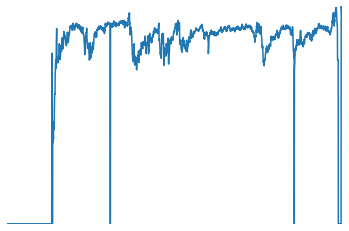

1302


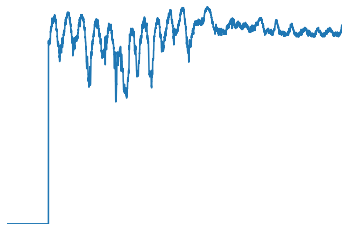

1071


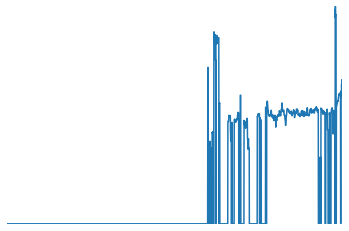

1094


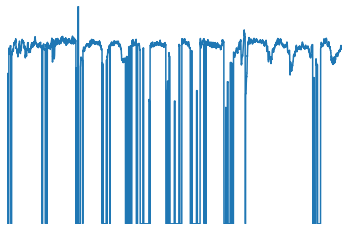

1029


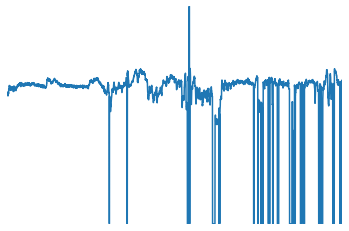

1248


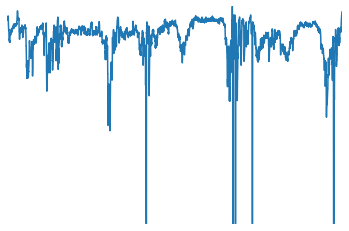

1002


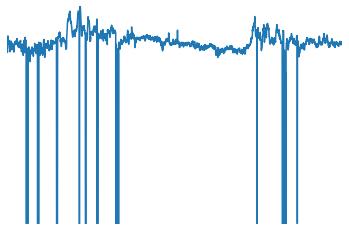

1341


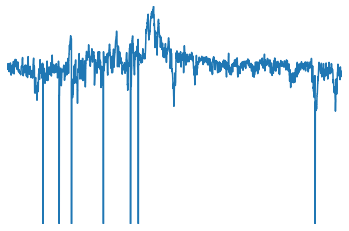

1009


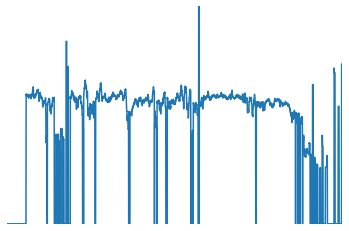

1332


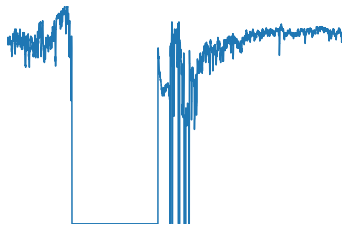

1466


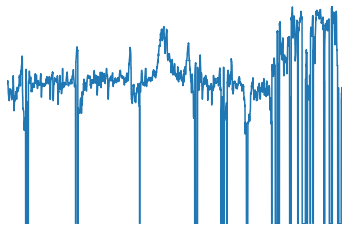

1391


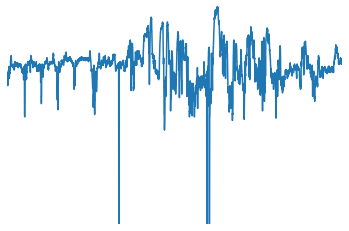

1097


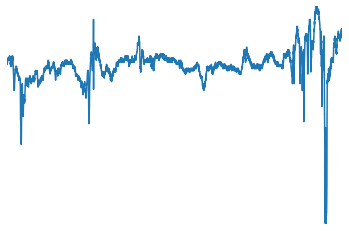

1443


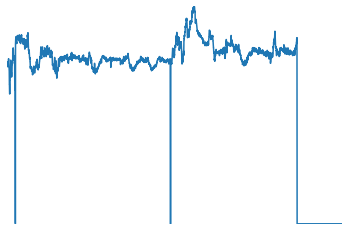

1114


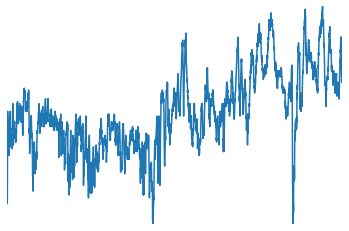

1478


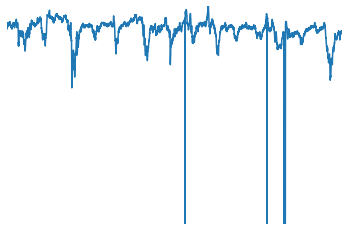

1352


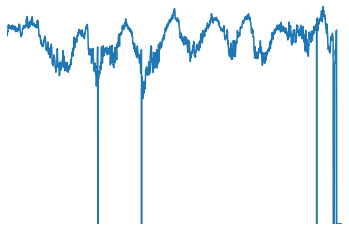

1014


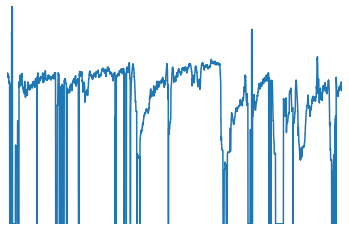

1217


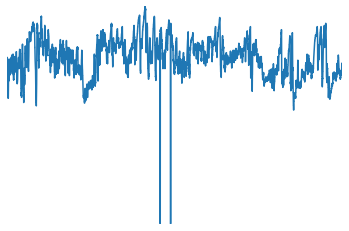

1155


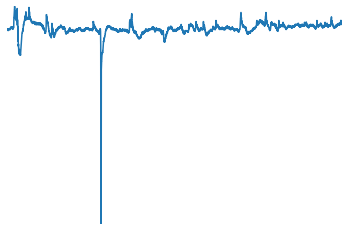

1442


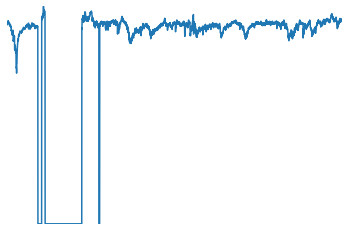

1440


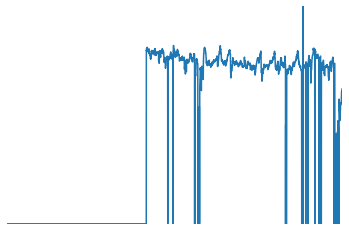

1344


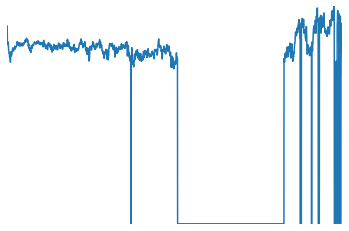

1076


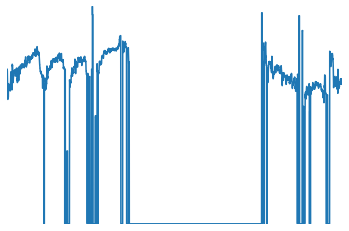

1472


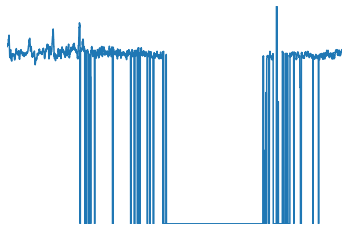

1281


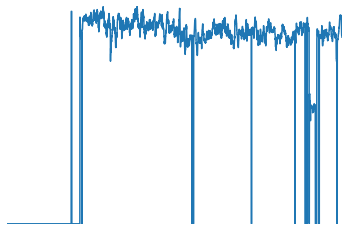

1070


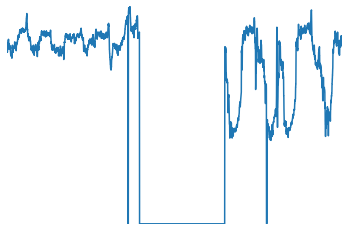

1034


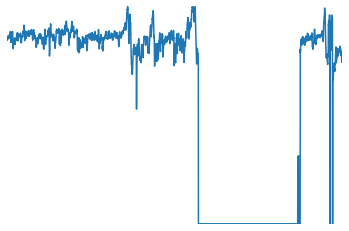

1292


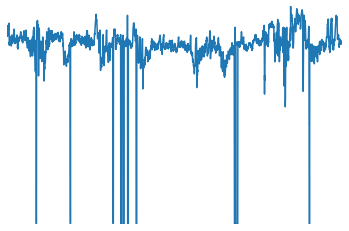

1285


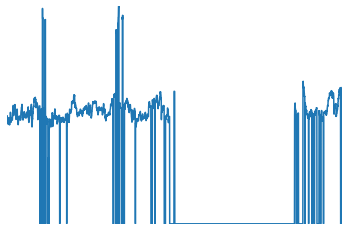

1306


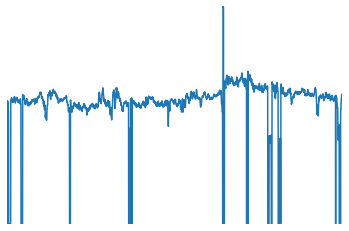

1303


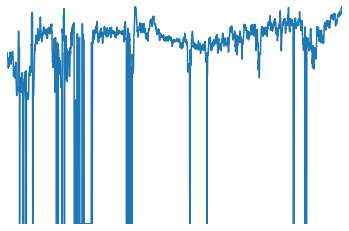

1279


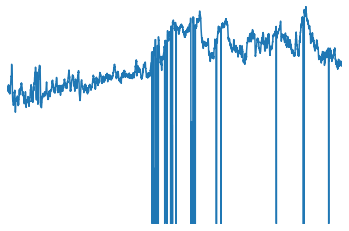

1105


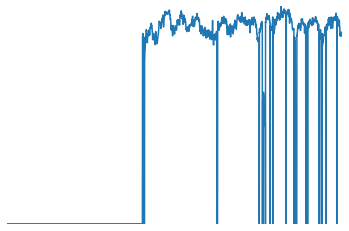

1418


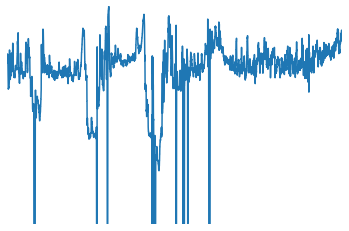

1253


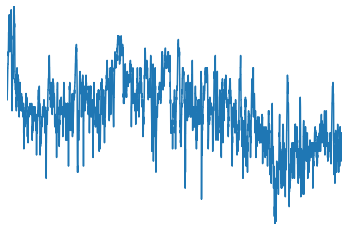

1172


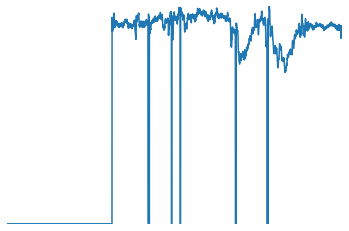

1325


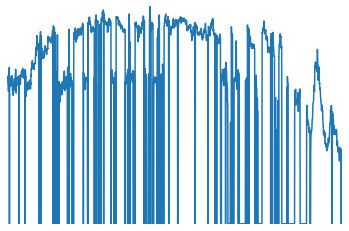

1367


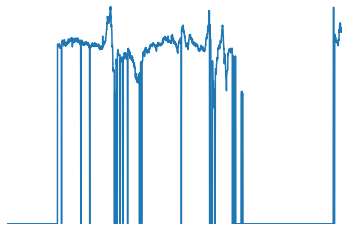

1362


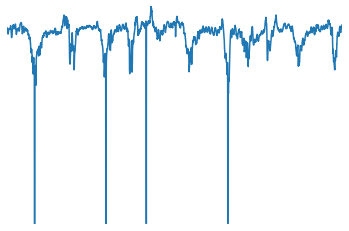

1048


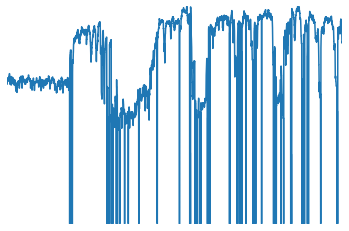

2034


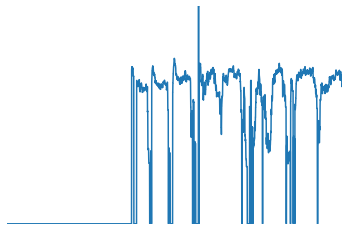

1042


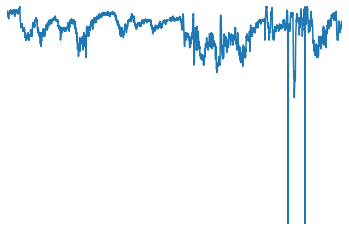

1270


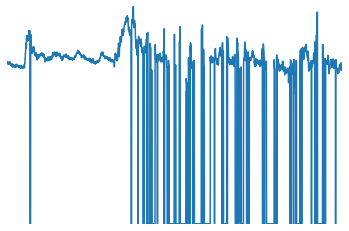

1368


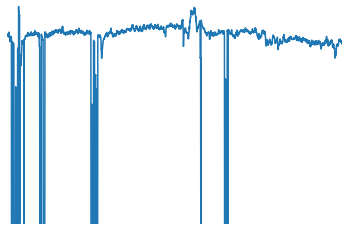

1079


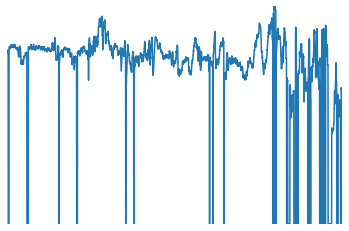

1384


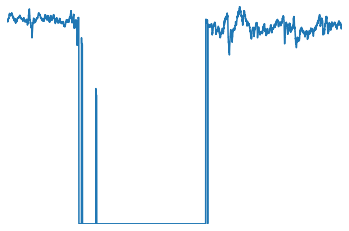

1113


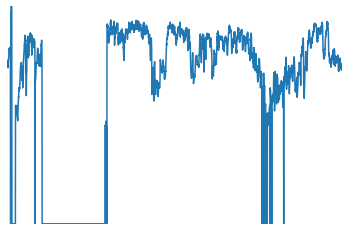

1315


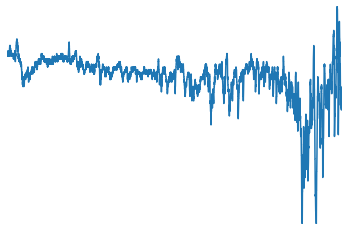

1053


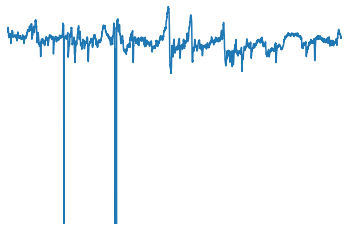

1220


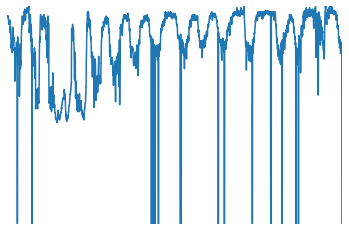

1023


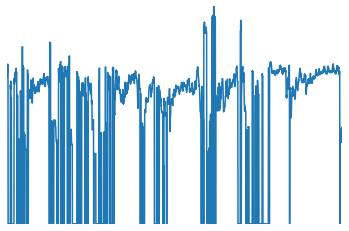

1275


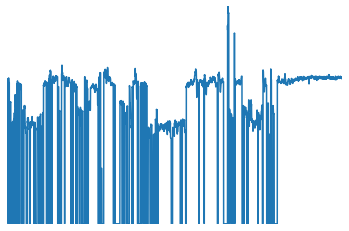

1493


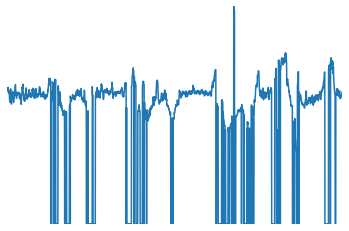

1101


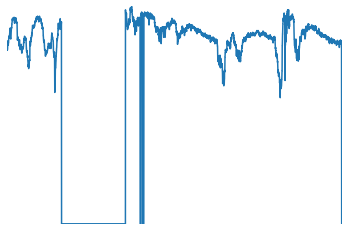

1360


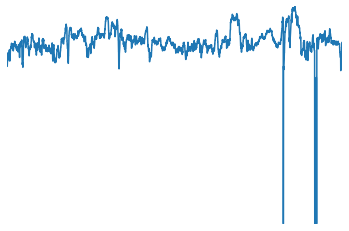

1261


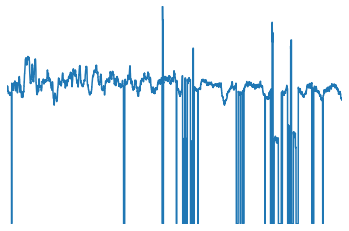

1298


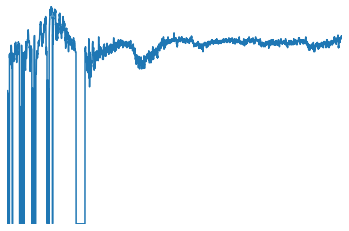

1063


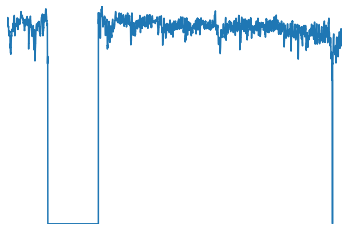

1050


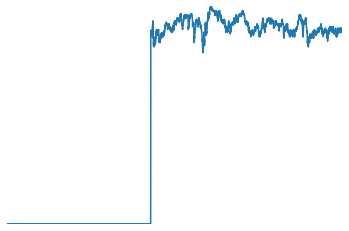

1132


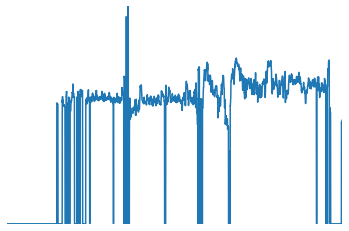

2004


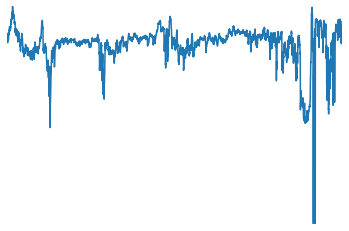

2015


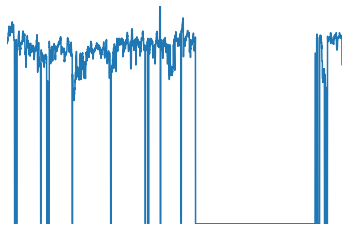

1474


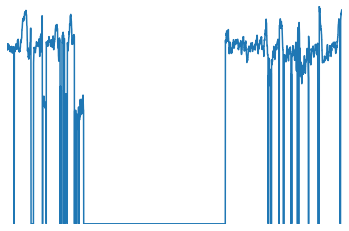

1100


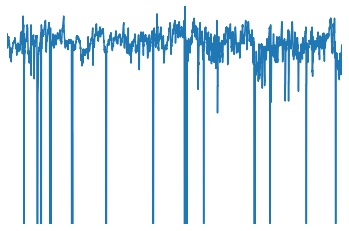

1333


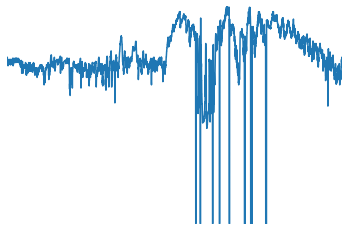

1020


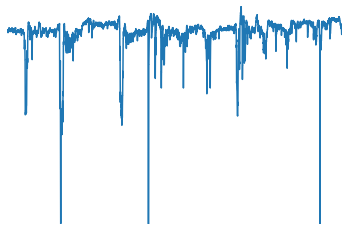

2017


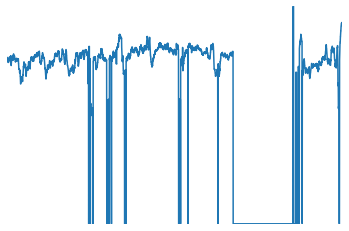

1295


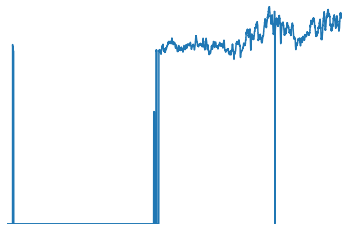

1189


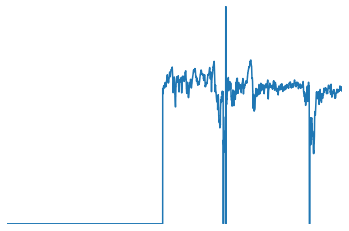

1027


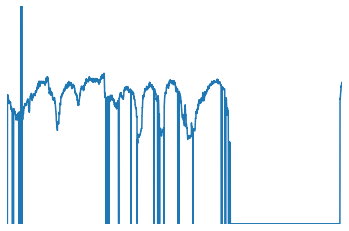

1304


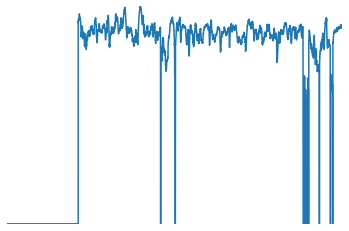

1491


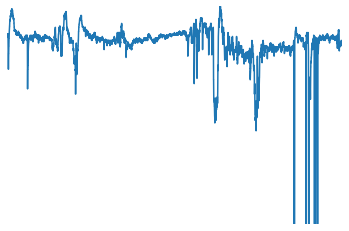

1176


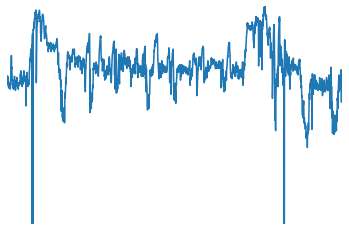

1329


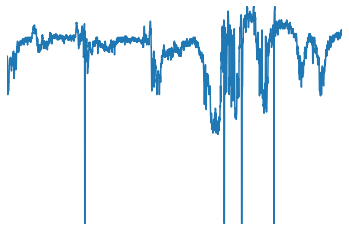

1394


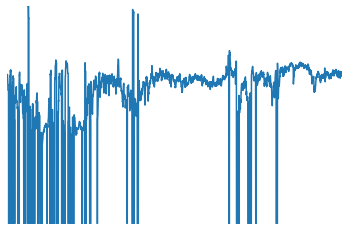

1005


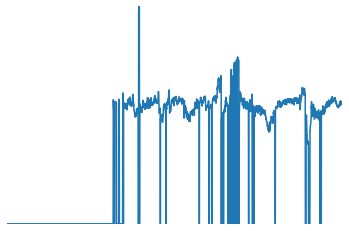

1349


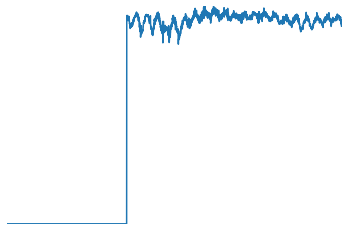

1147


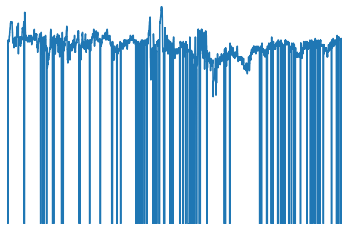

1297


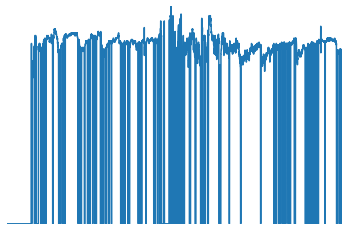

1354


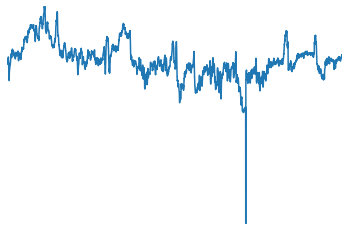

1262


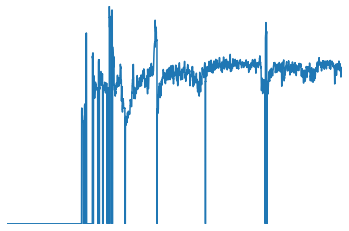

1339


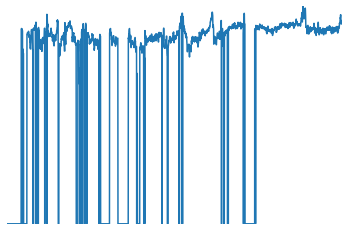

1498


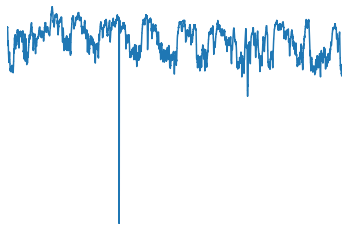

1488


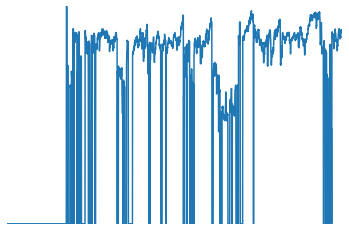

1198


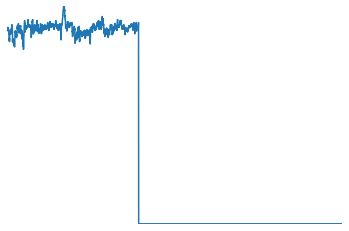

1169


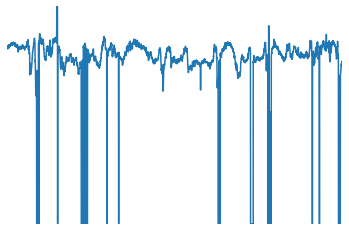

1032


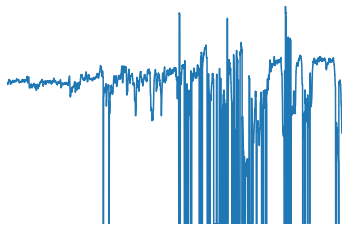

1124


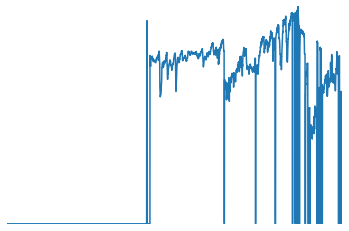

1040


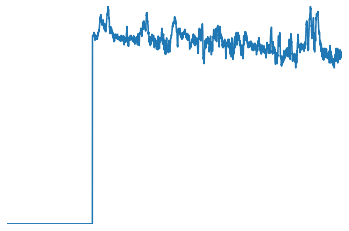

1376


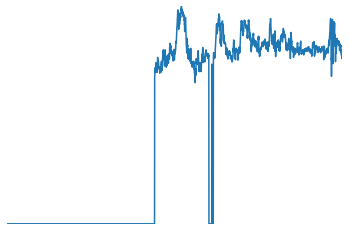

1423


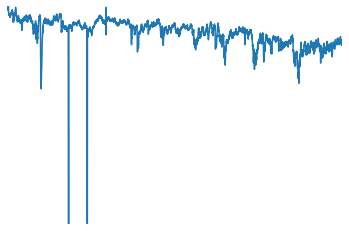

2010


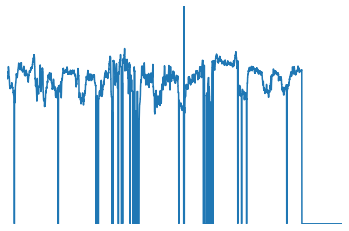

1410


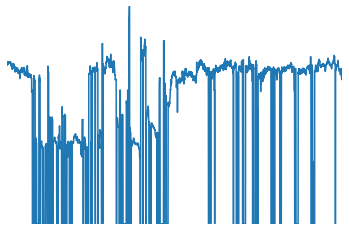

1152


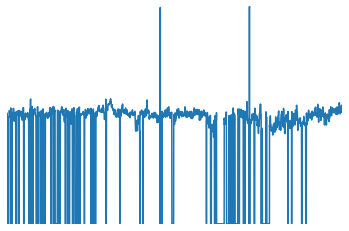

1431


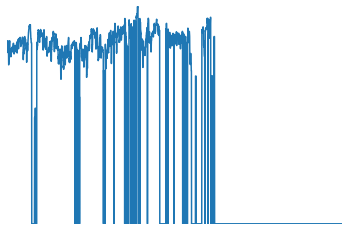

1203


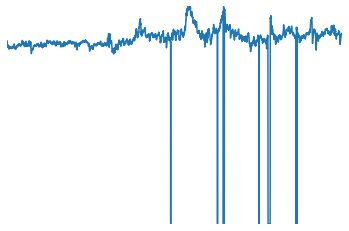

1229


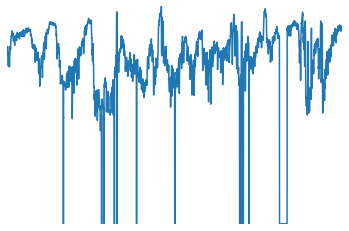

1276


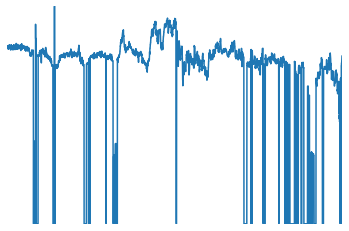

1127


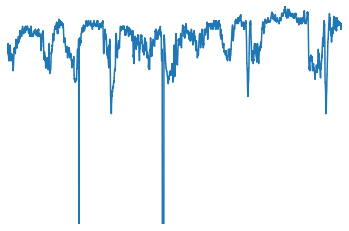

1108


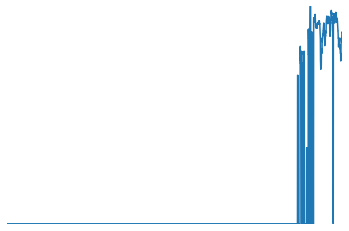

1081


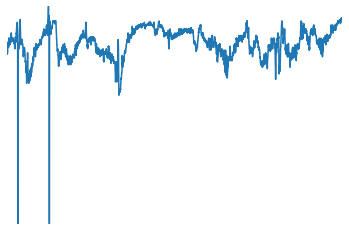

1249


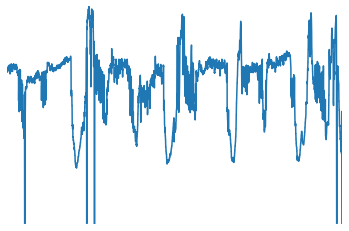

1409


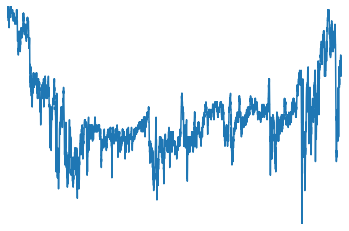

1138


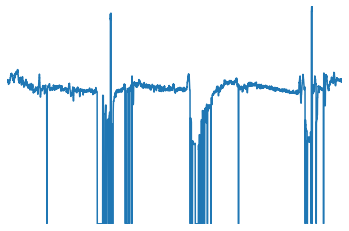

1039


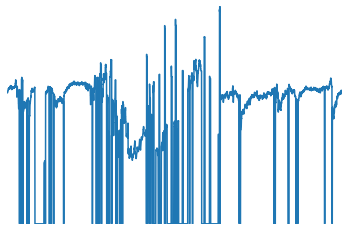

1047


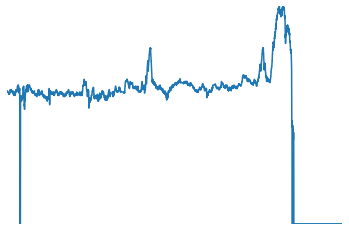

1351


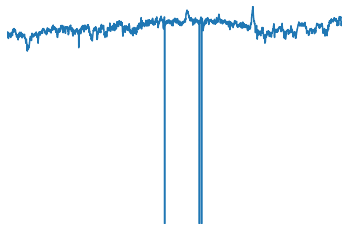

1064


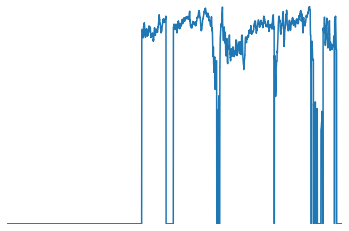

1450


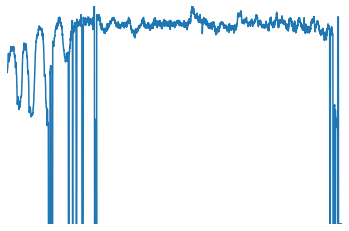

2029


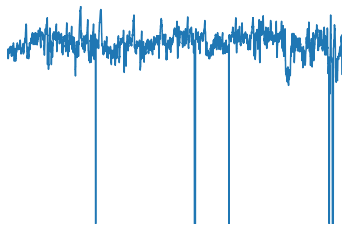

1326


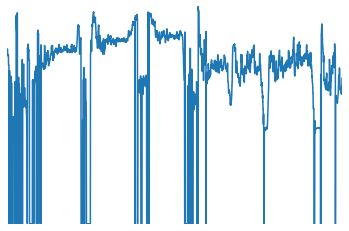

2031


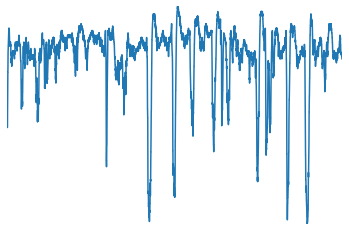

1243


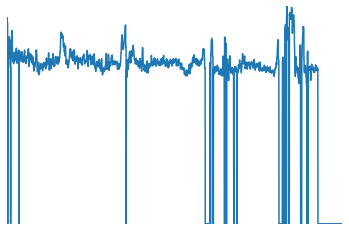

1026


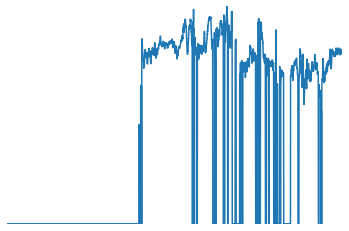

1393


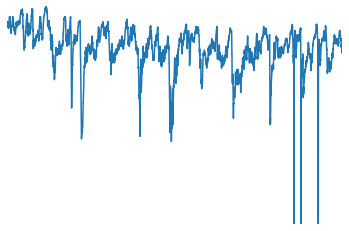

1140


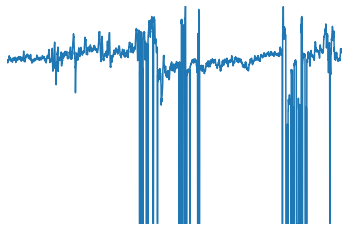

1346


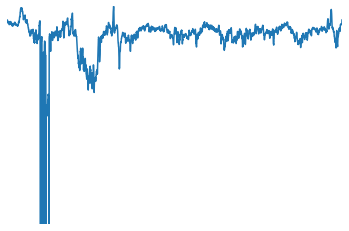

1102


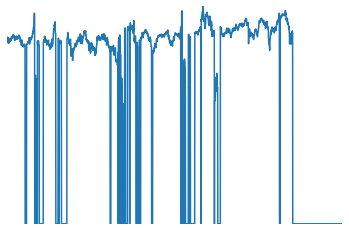

1057


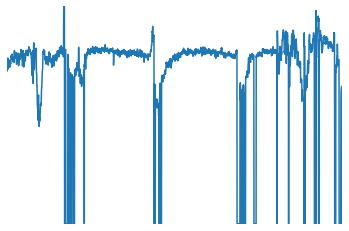

1125


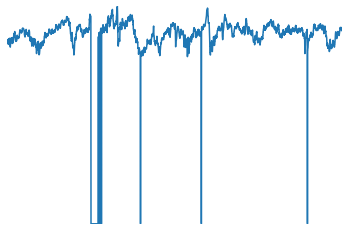

2038


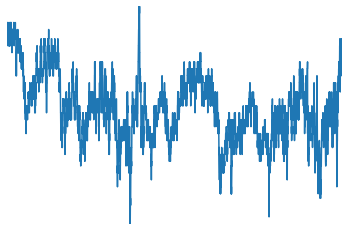

1145


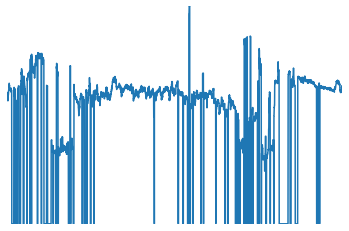

1004


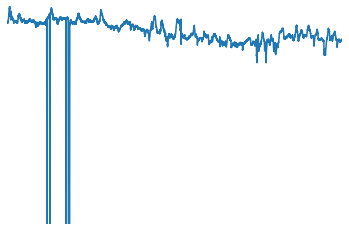

1133


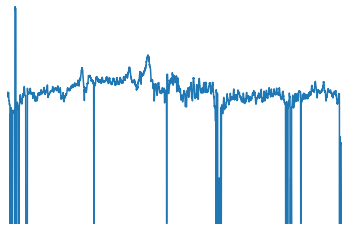

1464


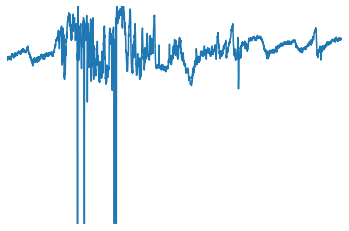

1142


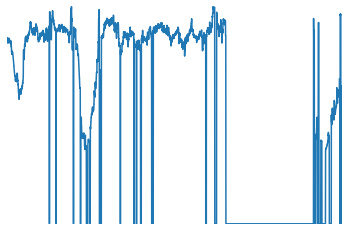

1330


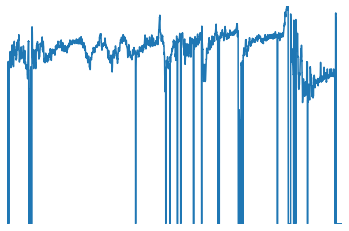

1166


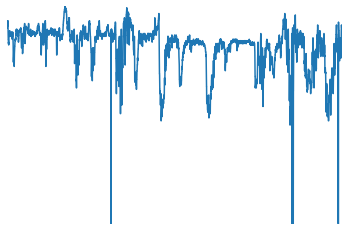

1350


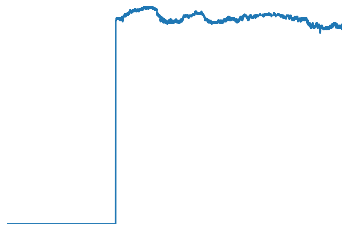

1467


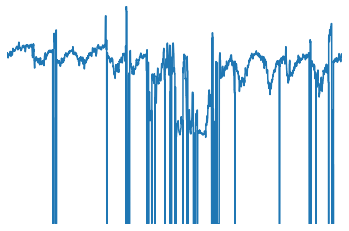

1117


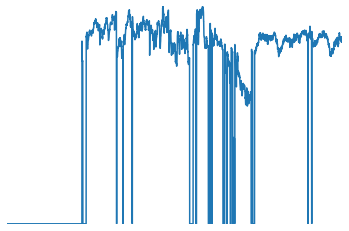

1111


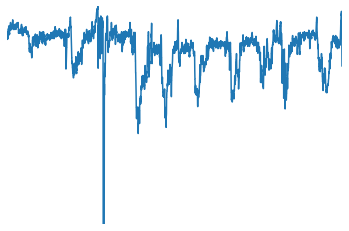

2035


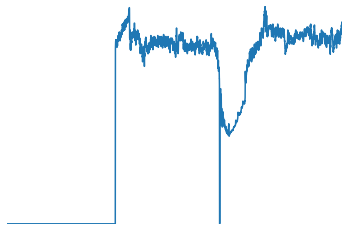

1236


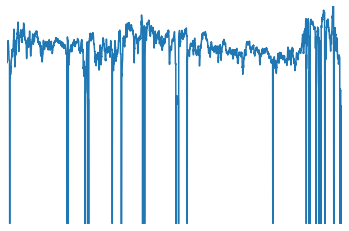

1413


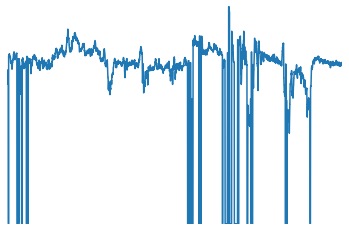

1290


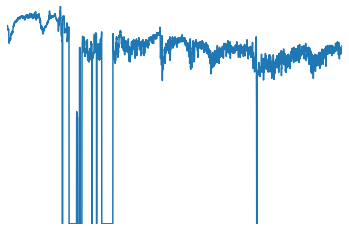

1232


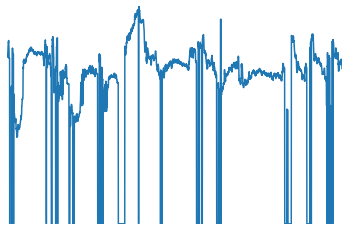

1355


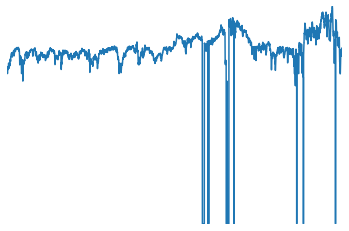

1052


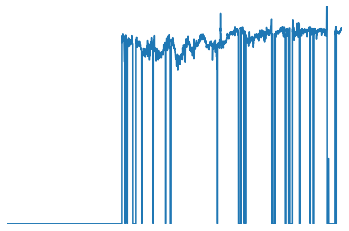

1324


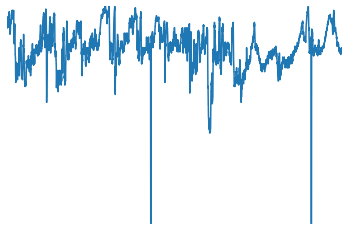

1449


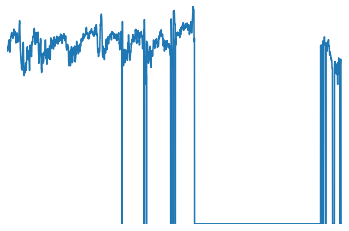

1080


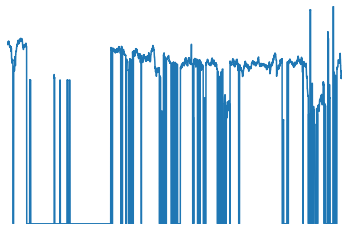

1055


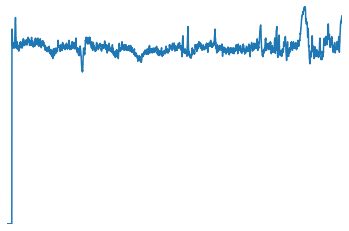

2026


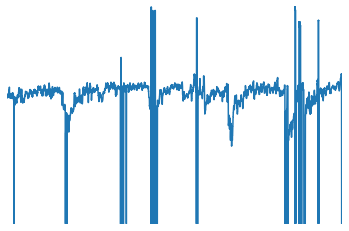

2011


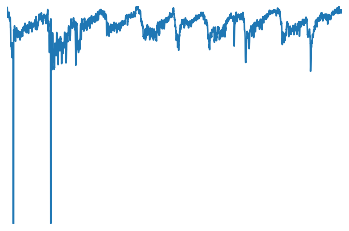

1407


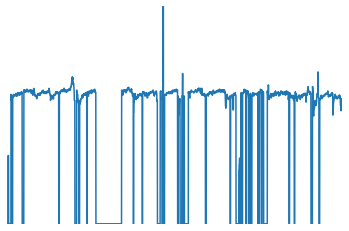

1036


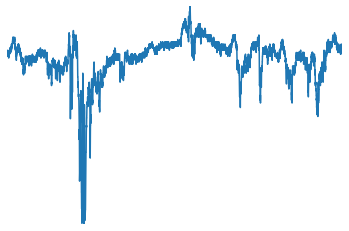

2001


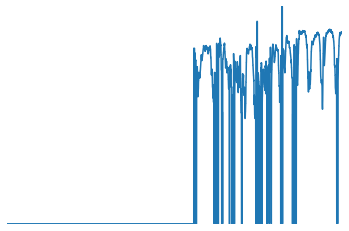

2002


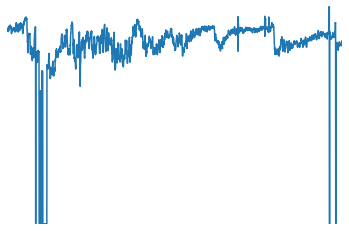

2018


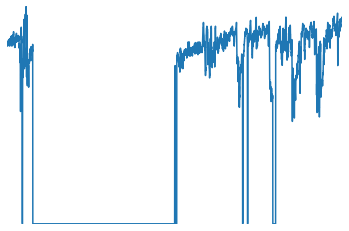

1336


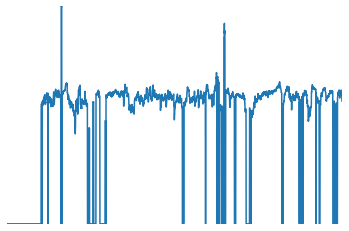

1506


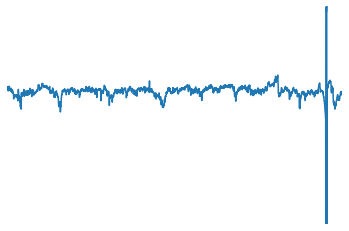

1205


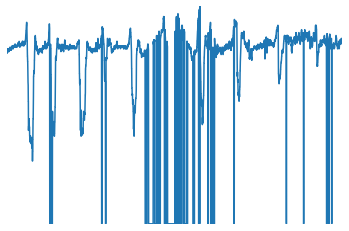

1016


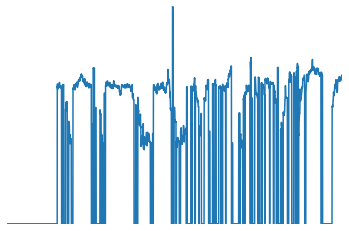

1408


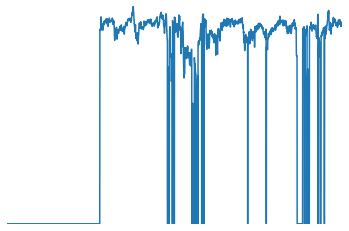

1146


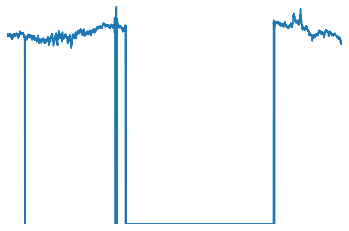

1268


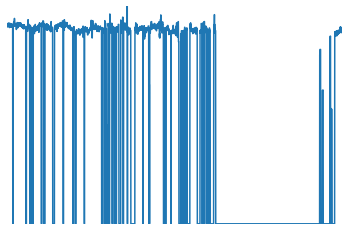

1144


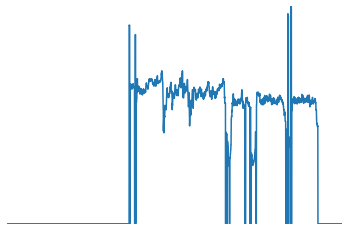

1067


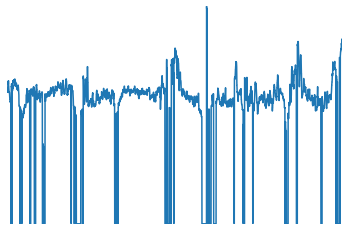

2043


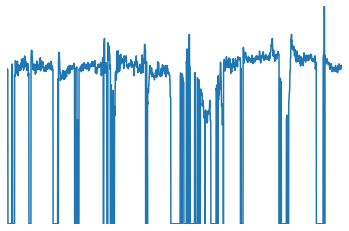

1345


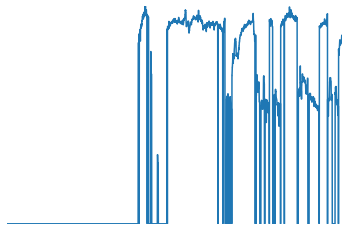

1199


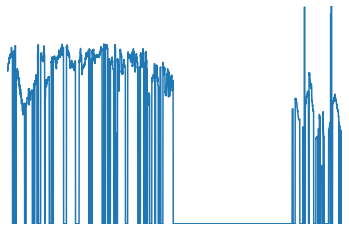

1403


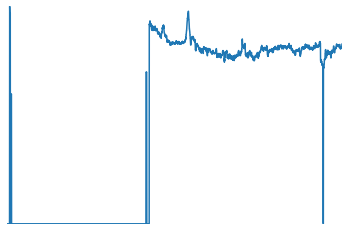

1293


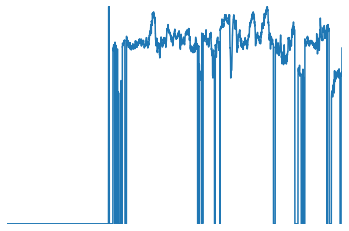

1486


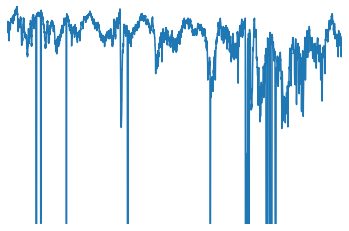

1342


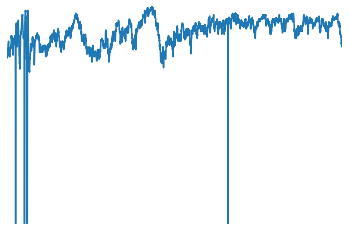

1174


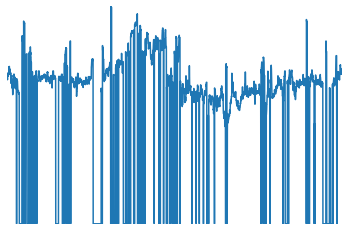

1165


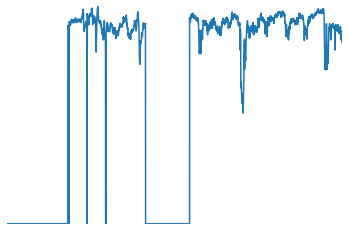

1296


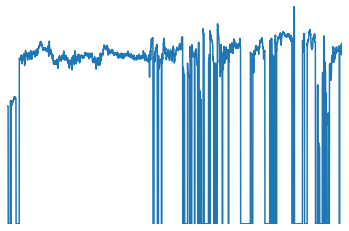

1313


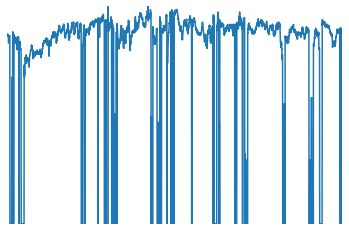

2044


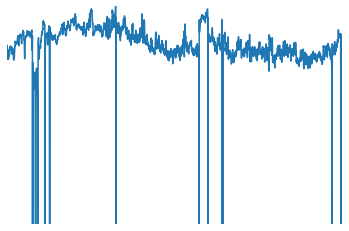

1438


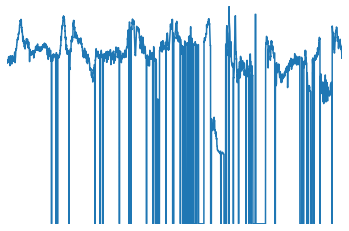

1272


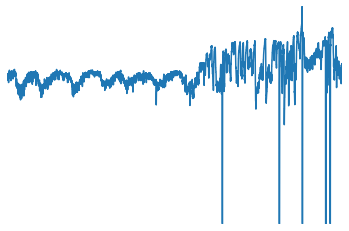

1338


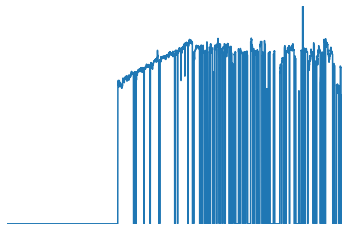

1180


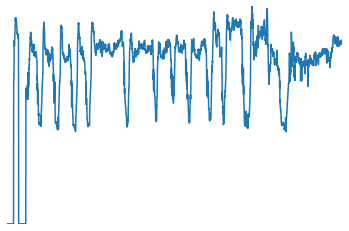

1173


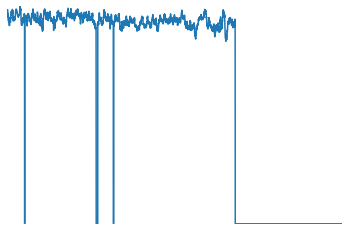

1419


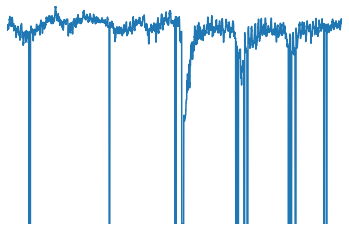

1008


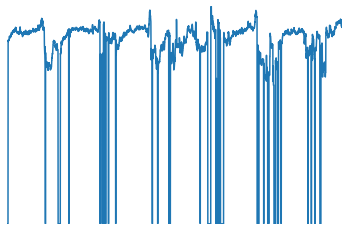

1200


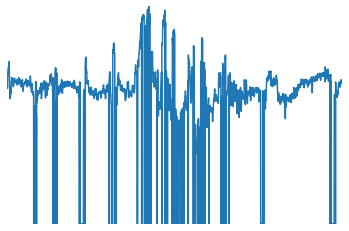

1386


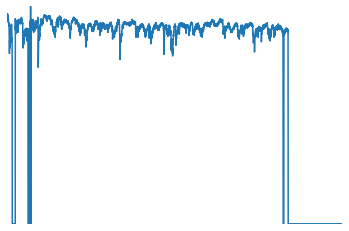

1416


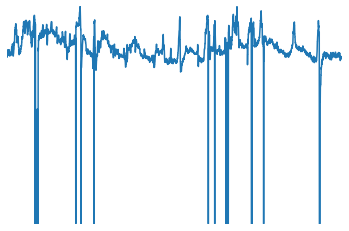

1119


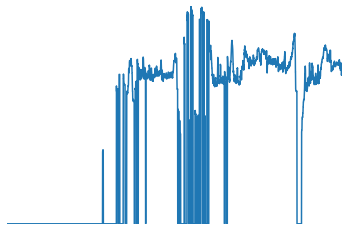

2028


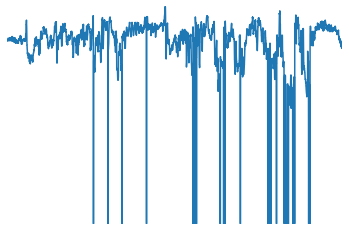

2027


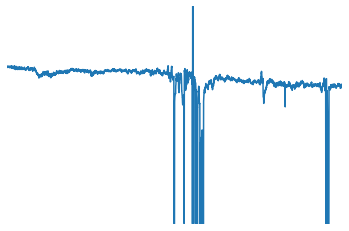

1044


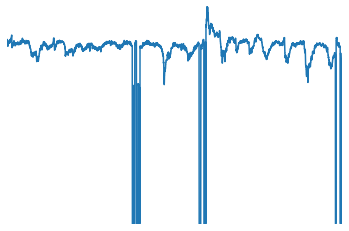

1420


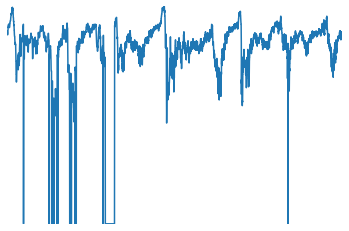

1402


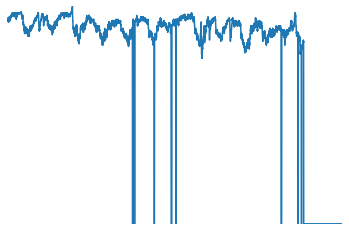

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(ts_data)):

  # printing sample name
  print(ts_data[i][1])

  # removing all extra things from the img plot (axis, whitespacing etc) 
  plt.title("")
  plt.axis('off')
  plt.margins(0)

  ## plotting and saving the sample
  plt.plot(ts_data[i][0][:7200])
  plt.savefig(f'/content/ts_plots/{ts_data[i][1]}.png')
  plt.show()

### Getting array representation of the plotted images

Using PIL, the plots are loaded back again. PIL automatically allows you to convert the image to a np array. We did so and the array is named **image_data**.

As out image data is quite large and color is irrelevant to the results, the image data was loaded back in a greyscale format to reduce processing costs. Otherwise colab would fail when training the model later. 

At the same time, when loading the image data, another numpy arrary was made to store the labels. **image_labels**. Image labels were stored as *1* if the sample had a resulting pH value of less than 7.3 (indicating fetal acidimea), else it was set to *0*. The image data for each sample and the image labels each were linked together by their respective index numbers. 

In [ ]:
from PIL import Image
import numpy as np

image_data = []
image_labels = []


for sample_num in ts_info:

  # reading image plots as grey scale and converting to np array
  image = Image.open(f'/content/ts_plots/{sample_num}.png').convert('L')
  data = np.asarray(image)

  # creating label for sample and appending to labels list
  if ts_info[sample_num]['pH'] < 7.3:
    image_labels.append(1)
  else:
    image_labels.append(0)
  image_data.append(data)

print(data.shape)

# converting to np array
image_labels = np.array(image_labels)
data = np.array(image_data)

(288, 432)


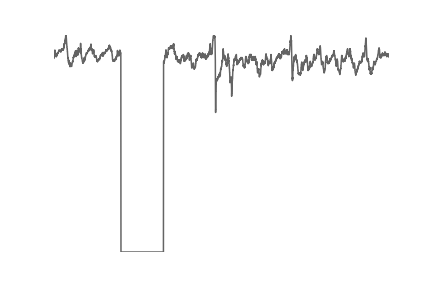

In [ ]:
Image.fromarray(image_data[0])

In [ ]:
image_data[0].shape

(288, 432)

# Training

### Logistic Regression

In [ ]:
#flattening images to pass to model

flattened_images = []

for example in image_data:
  flattened_images.append(example.flatten().astype('float64'))


In [ ]:
flattened_images = np.array(flattened_images) # converting to np array

In [ ]:
print(flattened_images.shape)
print(image_labels.shape)

(552, 124416)
(552,)


In [ ]:
# spliting data into train and test data (70/30 ratio)

to_split = flattened_images.shape[0] * 0.7
train_data, test_data = np.split(flattened_images, [int(to_split)])
train_labels, test_labels = np.split(image_labels, [int(to_split)])

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(386, 124416)
(386,)
(166, 124416)
(166,)


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
reg = LogisticRegression().fit(train_data, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
score = reg.score(test_data, test_labels)
score * 100

59.036144578313255

### Feed Forward Network

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [ ]:
# spliting data into train and test data (70/30 ratio)
to_split = data.shape[0] * 0.7
train_data, test_data = np.split(data, [int(to_split)])
train_labels, test_labels = np.split(labels, [int(to_split)])

In [ ]:
# converting labels to categorical representation

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(386, 288, 432)
(386, 2)
(166, 288, 432)
(166, 2)


In [ ]:
ffn = Sequential()

ffn.add(Flatten(input_shape=(288,432)))

ffn.add(Dense(units=900, activation="relu"))
ffn.add(Dropout(0.30))

ffn.add(Dense(units=900, activation="relu"))
ffn.add(Dropout(0.30))

ffn.add(Dense(units=2, activation="softmax"))

In [ ]:
ffn.compile(optimizer="adamax", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = ffn.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
2/2 [==============================] - 1s 348ms/step - loss: 20880.8764 - accuracy: 0.5949 - val_loss: 22701.5156 - val_accuracy: 0.3072
Epoch 2/50
2/2 [==============================] - 0s 186ms/step - loss: 21128.0599 - accuracy: 0.5752 - val_loss: 17790.6055 - val_accuracy: 0.6928
Epoch 3/50
2/2 [==============================] - 0s 172ms/step - loss: 17441.6979 - accuracy: 0.7171 - val_loss: 14970.2881 - val_accuracy: 0.6928
Epoch 4/50
2/2 [==============================] - 0s 168ms/step - loss: 14205.0768 - accuracy: 0.7158 - val_loss: 5493.0317 - val_accuracy: 0.6928
Epoch 5/50
2/2 [==============================] - 0s 176ms/step - loss: 6992.4209 - accuracy: 0.7094 - val_loss: 1851.6713 - val_accuracy: 0.3072
Epoch 6/50
2/2 [==============================] - 0s 172ms/step - loss: 4973.0975 - accuracy: 0.4520 - val_loss: 6173.8086 - val_accuracy: 0.3072
Epoch 7/50
2/2 [==============================] - 0s 171ms/step - loss: 5002.4497 - accuracy: 0.5700 - val_loss: 1603

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 124416)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 900)               111975300 
_________________________________________________________________
dropout_12 (Dropout)         (None, 900)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 900)               810900    
_________________________________________________________________
dropout_13 (Dropout)         (None, 900)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1802      
Total params: 112,788,002
Trainable params: 112,788,002
Non-trainable params: 0
________________________________________

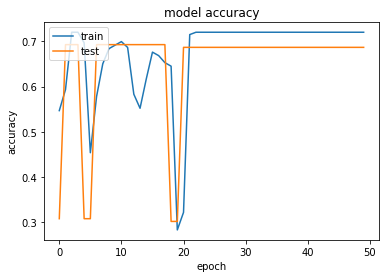

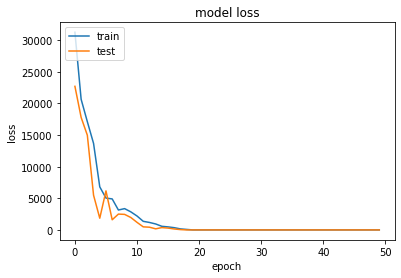

In [ ]:
ffn.summary()
#Key​ elements that we will be analysing on graph
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### CNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU


In [ ]:
# reshaping data as CNN in Keras requires 3-dimensional data to be passed
# we have 2-d greyscale image in an array so an extra channel needs to be added for the data to be used by the model

reshaped_data = np.reshape(data, (552, 288, 432, 1))
reshaped_data.shape

(552, 288, 432, 1)

In [ ]:
# spliting data into train and test data (75/25 ratio)

to_split = reshaped_data.shape[0] * 0.75
train_data, test_data = np.split(reshaped_data, [int(to_split)])
train_labels, test_labels = np.split(labels, [int(to_split)])

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(414, 288, 432, 1)
(414, 2)
(138, 288, 432, 1)
(138, 2)


In [ ]:
cnn = Sequential()

cnn.add(Conv2D(128, kernel_size=(3, 3), activation="linear", padding="same", input_shape=(288, 432, 1)))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D((3, 3), padding="same"))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(128, kernel_size=(3, 3), activation="linear", padding="same"))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D((3, 3), padding="same"))
cnn.add(Dropout(0.4))

cnn.add(Conv2D(128, kernel_size=(3, 3), activation="linear", padding="same"))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D((3, 3), padding="same"))
cnn.add(Dropout(0.3))


cnn.add(Flatten())

cnn.add(Dense(128, activation='linear', kernel_initializer='he_uniform'))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(Dropout(0.2))

cnn.add(Dense(2, activation='softmax'))


In [ ]:
cnn.compile(optimizer="adamax", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = cnn.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=50, batch_size=32)

Epoch 1/50
13/13 [==============================] - 14s 765ms/step - loss: 391.4147 - accuracy: 0.6176 - val_loss: 62.9932 - val_accuracy: 0.3043
Epoch 2/50
13/13 [==============================] - 7s 552ms/step - loss: 21.6852 - accuracy: 0.6679 - val_loss: 1.3949 - val_accuracy: 0.3043
Epoch 3/50
13/13 [==============================] - 7s 554ms/step - loss: 2.4434 - accuracy: 0.7006 - val_loss: 0.7637 - val_accuracy: 0.6014
Epoch 4/50
13/13 [==============================] - 7s 555ms/step - loss: 1.7532 - accuracy: 0.6745 - val_loss: 2.2801 - val_accuracy: 0.6884
Epoch 5/50
13/13 [==============================] - 7s 554ms/step - loss: 1.6010 - accuracy: 0.6802 - val_loss: 4.6760 - val_accuracy: 0.6957
Epoch 6/50
13/13 [==============================] - 7s 555ms/step - loss: 1.3802 - accuracy: 0.6484 - val_loss: 10.6699 - val_accuracy: 0.6957
Epoch 7/50
13/13 [==============================] - 7s 554ms/step - loss: 1.1013 - accuracy: 0.7147 - val_loss: 14.7483 - val_accuracy: 0.6957

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 288, 432, 128)     1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 288, 432, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 144, 128)      0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 144, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 144, 128)      147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 144, 128)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 48, 128)       0

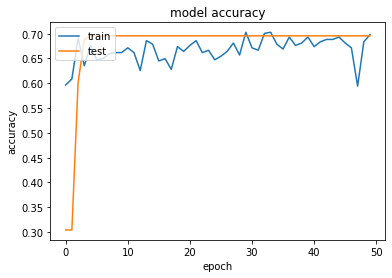

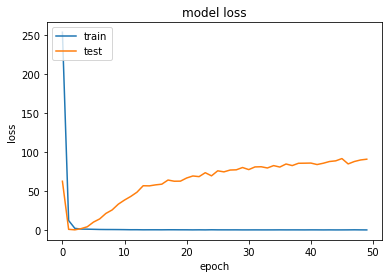

In [ ]:
cnn.summary()
#Key​ elements that we will be analysing on graph
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### VGG

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.vgg16 import preprocess_input, VGG16


In [ ]:
data.shape

(552, 288, 432)

Here the greyscale image is converted to a RGB representation as the input layer to VGG only takes 3 channel images. CV2 is used for this purpose.

In [ ]:
import cv2

rgb_image_data = []

for grey_image in image_data:
  backtorgb = cv2.cvtColor(data[0],cv2.COLOR_GRAY2RGB)
  rgb_image_data.append(backtorgb)

rgb_image_data = np.array(rgb_image_data)

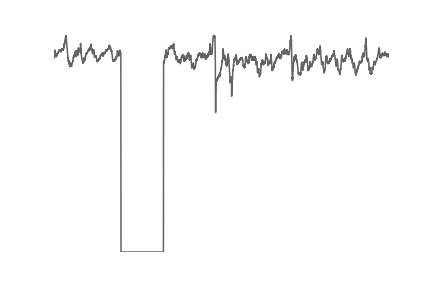

In [ ]:
Image.fromarray(rgb_image_data[0])

In [ ]:
to_split = rgb_image_data.shape[0] * 0.75
train_data, test_data = np.split(rgb_image_data, [int(to_split)])
train_labels, test_labels = np.split(labels, [int(to_split)])

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(414, 288, 432, 3)
(414, 2)
(138, 288, 432, 3)
(138, 2)


In [ ]:
# making VGG16 layers be untrainable and defining the input shape

vgg = VGG16(weights="imagenet", include_top=False, input_shape=(288, 432, 3))

for i in vgg.layers:
  i.trainable = False


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
ffn = Sequential()

ffn.add(vgg)

ffn.add(Flatten())

ffn.add(Dense(units=200, activation="relu"))
ffn.add(Dropout(0.3))


ffn.add(Dense(units=300, activation="linear"))
ffn.add(Dropout(0.3))

ffn.add(Dense(units=2, activation="softmax"))

In [ ]:
ffn.compile(optimizer="adamax", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = ffn.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=30, batch_size=16)

Epoch 1/30
26/26 [==============================] - 11s 389ms/step - loss: 0.6254 - accuracy: 0.7044 - val_loss: 0.6223 - val_accuracy: 0.6957
Epoch 2/30
26/26 [==============================] - 10s 381ms/step - loss: 0.6233 - accuracy: 0.6920 - val_loss: 0.6168 - val_accuracy: 0.6957
Epoch 3/30
26/26 [==============================] - 10s 381ms/step - loss: 0.5976 - accuracy: 0.7205 - val_loss: 0.6147 - val_accuracy: 0.6957
Epoch 4/30
26/26 [==============================] - 10s 380ms/step - loss: 0.5641 - accuracy: 0.7594 - val_loss: 0.6146 - val_accuracy: 0.6957
Epoch 5/30
26/26 [==============================] - 10s 380ms/step - loss: 0.5941 - accuracy: 0.7183 - val_loss: 0.6149 - val_accuracy: 0.6957
Epoch 6/30
26/26 [==============================] - 10s 380ms/step - loss: 0.5890 - accuracy: 0.7248 - val_loss: 0.6154 - val_accuracy: 0.6957
Epoch 7/30
26/26 [==============================] - 10s 380ms/step - loss: 0.5735 - accuracy: 0.7414 - val_loss: 0.6156 - val_accuracy: 0.6957

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 13, 512)        14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 59904)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               11981000  
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                

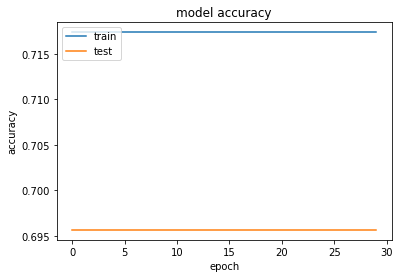

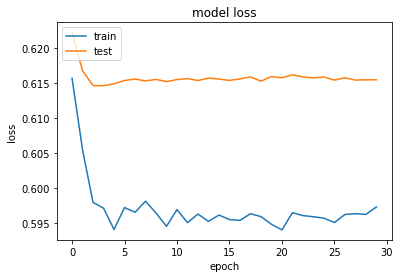

In [ ]:
ffn.summary()
#Key​ elements that we will be analysing on graph
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
